In [1]:
import ete3
import pandas as pd
import re
import multiprocessing
import numpy as np
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn import manifold
import networkx as nx
import community
import random
import collections
import operator

%cd /work/kelsey/hgt/

/work/kelsey/hgt


In [2]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [3]:
tree              = ete3.Tree('species_tree')
ranger_named_tree = ete3.Tree('species_tree_named_nodes', format=1)

genomes           = pd.read_csv('../genomes.tab', sep='\t', index_col=0)
genomes.Organism  = genomes.Organism.replace('\s+\(.+\)$', '', regex=True)

transfer_df       = pd.read_csv('transfers-filtered_by_confidence.tab', sep='\t', index_col=0)

name_conversion = {}
for index, row in genomes.iterrows():
    if index.startswith('GC'):
        name_conversion[row.abbreviation] = re.sub('\.\d+$', '', index, flags=re.M).replace('_', '')
    else:
        name_conversion[row.abbreviation] = row.accession.replace('_', '')

for leaf in tree.get_leaves():
    if leaf.name in name_conversion:
        leaf.add_feature('accession', name_conversion[leaf.name])
    else:
        leaf.add_feature('accession', leaf.name.replace('_', ''))

In [4]:
name_table = pd.DataFrame(columns=['name', 'accession'],
                          data=[(leaf.name, leaf.accession) for leaf in tree.get_leaves()])

for node in ranger_named_tree.traverse():
    if node.is_leaf():
        continue

    descendants     = name_table.loc[name_table.accession.isin(node.get_leaf_names()),
                                     'name'].values.tolist()
    equivalent      = tree.get_common_ancestor(descendants)
    equivalent.name = node.name

In [5]:
constraints = list(
    transfer_df.groupby(['donor', 'recipient']).groups.keys()
)

In [6]:
null_tree = tree.copy()
null_tree.convert_to_ultrametric()
for node in null_tree.traverse():
    node.add_feature('age',
                     sum([ancestor.dist for ancestor in node.get_ancestors()])
                    )

uninformative_constraints = set()
for donor_name, recipient_name in set(constraints):
    donor     = next(null_tree.iter_search_nodes(name=donor_name))
    recipient = next(null_tree.iter_search_nodes(name=recipient_name))
    
    if donor.age < recipient.age:
        uninformative_constraints.add((donor_name, recipient_name))

#compatibility_table.drop(columns=uninformative_constraints, inplace=True)
#constraints = compatibility_table.columns.tolist()

In [8]:
posterior_trees = [ete3.Tree(line)
                   for line in open('Cyano_modelBB_long_ugam_bd_7_20_sample.datedist').readlines()]

In [8]:
posterior_trees_random_ages = []
for _ in posterior_trees:
    tmp_tree = _.copy()
    
    branch_lengths = [node.dist
                      for node in tmp_tree.traverse() if not node.is_root()]
    random.shuffle(branch_lengths)

    for count, node in enumerate(tmp_tree.traverse(), -1):
        if node.is_root():
            continue
        node.dist = branch_lengths[count]
        
    for node in tmp_tree.traverse():
        node.add_feature('age',
                         sum([ancestor.dist for ancestor in node.get_ancestors()])
                        )

In [51]:
a = posterior_trees[0].copy()

In [48]:
branch_lengths = [node.dist for node in a.traverse() if not node.is_root()]
random.shuffle(branch_lengths)

for count, node in enumerate(a.traverse(), -1):
    if node.is_root():
        continue
    node.dist = branch_lengths[count]

In [49]:
a.support

3947.91

In [68]:
node_ages  = []
br_length  = []
time_spans = []
age_estimation = []
for n in a.traverse():
    if n.is_root():
        continue

    ancestor_age = next(n.iter_ancestors()).support
    time_spans.append(ancestor_age-n.support)
    node_ages.append(n.support)
    br_length.append(n.dist)
    
    if not n.is_leaf():
        tmp     = n.children[0]
        tmp_age = tmp.dist
        while not tmp.is_leaf():
            tmp = tmp.children[0]
            tmp_age += tmp.dist
    
        age_estimation.append(tmp_age)
    else:
        age_estimation.append(1.0)

In [67]:
a.get_leaves()[0].support

1.0

In [69]:
node_ages

[3659.38,
 3569.01,
 2565.89,
 2659.82,
 2011.7,
 3267.69,
 2396.73,
 2206.94,
 1.0,
 2238.45,
 1657.73,
 1898.89,
 1651.13,
 2889.89,
 435.77,
 1896.05,
 1.0,
 1929.43,
 1657.39,
 2001.2,
 1.0,
 1144.86,
 1613.2,
 1169.26,
 1.0,
 980.87,
 420.294,
 2705.55,
 1.0,
 1.0,
 1659.16,
 1.0,
 1740.36,
 1630.21,
 626.19,
 1198.63,
 1609.66,
 1740.54,
 1.0,
 1.0,
 1216.64,
 853.7,
 1.0,
 1.0,
 1.0,
 294.498,
 1.0,
 1.0,
 1.0,
 2521.8,
 433.551,
 712.898,
 1.0,
 561.405,
 1466.02,
 1229.69,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1001.78,
 1.0,
 1658.51,
 1.0,
 464.622,
 1.0,
 373.547,
 211.523,
 1.0,
 2192.2,
 2416.57,
 1.0,
 1.0,
 580.323,
 159.754,
 1.0,
 1.0,
 1.0,
 1021.86,
 1.0,
 1114.09,
 878.785,
 863.159,
 1.0,
 722.1,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1753.17,
 695.61,
 2265.16,
 318.623,
 478.324,
 1.0,
 1.0,
 608.239,
 920.838,
 1.0,
 600.536,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1634.81,
 1.0,
 1.0,
 470.091,
 2183.8,
 1.0,
 1.0,
 353.301,
 420.701,
 1.0,
 1.0,
 1.0,
 560.418

In [70]:
age_estimation

[3659.3740000000003,
 3569.008,
 2565.884,
 2659.82,
 2011.708,
 3267.6800000000003,
 2396.73,
 2206.94,
 1,
 2238.443,
 1657.73,
 1898.8890000000001,
 1651.13,
 2889.894,
 435.77,
 1896.042,
 1,
 1929.4289999999999,
 1657.39,
 2001.203,
 1,
 1144.86,
 1613.2,
 1169.26,
 1,
 980.87,
 420.294,
 2705.55,
 1,
 1,
 1659.1609999999998,
 1,
 1740.36,
 1630.215,
 626.19,
 1198.63,
 1609.66,
 1740.54,
 1,
 1,
 1216.64,
 853.7,
 1,
 1,
 1,
 294.4981,
 1,
 1,
 1,
 2521.8019999999997,
 433.551,
 712.8969999999999,
 1,
 561.405,
 1466.02,
 1229.69,
 1,
 1,
 1,
 1,
 1,
 1001.784,
 1,
 1658.51,
 1,
 464.622,
 1,
 373.547,
 211.523,
 1,
 2192.2,
 2416.57,
 1,
 1,
 580.323,
 159.754,
 1,
 1,
 1,
 1021.857,
 1,
 1114.09,
 878.785,
 863.159,
 1,
 722.1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1753.17,
 695.61,
 2265.16,
 318.623,
 478.32399999999996,
 1,
 1,
 608.239,
 920.838,
 1,
 600.536,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1634.808,
 1,
 1,
 470.09,
 2183.798,
 1,
 1,
 353.301,
 420.701,
 1,
 1,
 1,
 560.418,
 1,
 1,

In [7]:
def assess_constraint_compatibility(constraint):
    older_bound   = next(tree.iter_search_nodes(name=constraint[0]))
    younger_bound = next(tree.iter_search_nodes(name=constraint[1]))
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [116]:
pool    = multiprocessing.Pool(processes=20)
results = pool.map(assess_constraint_compatibility, constraints)

compatibility_table = pd.DataFrame(columns=constraints,
                                   data   =np.array(results).T)

compatibility_count      = compatibility_table.sum()
compatibility_count.name = 'compatibility_count'

In [132]:
len(uninformative_constraints)

283

In [9]:
def jaccard_between_constraints(constraints):
    intersection = sum(compatibility_table[constraints].T.all())
    union        = sum(compatibility_table[constraints].T.any())
    
    if not union:
        return(0.0)
    else:
        return(intersection/union)

In [120]:
pairs_of_constraints = [list(pair) for pair in itertools.combinations(constraints, 2)]

In [121]:
pool                = multiprocessing.Pool(processes=20)
condensed_distances = np.array(
    pool.map(jaccard_between_constraints, pairs_of_constraints)
)

jaccard_distances = pd.DataFrame(index=constraints,
                                 columns=constraints,
                                 data=squareform(condensed_distances))

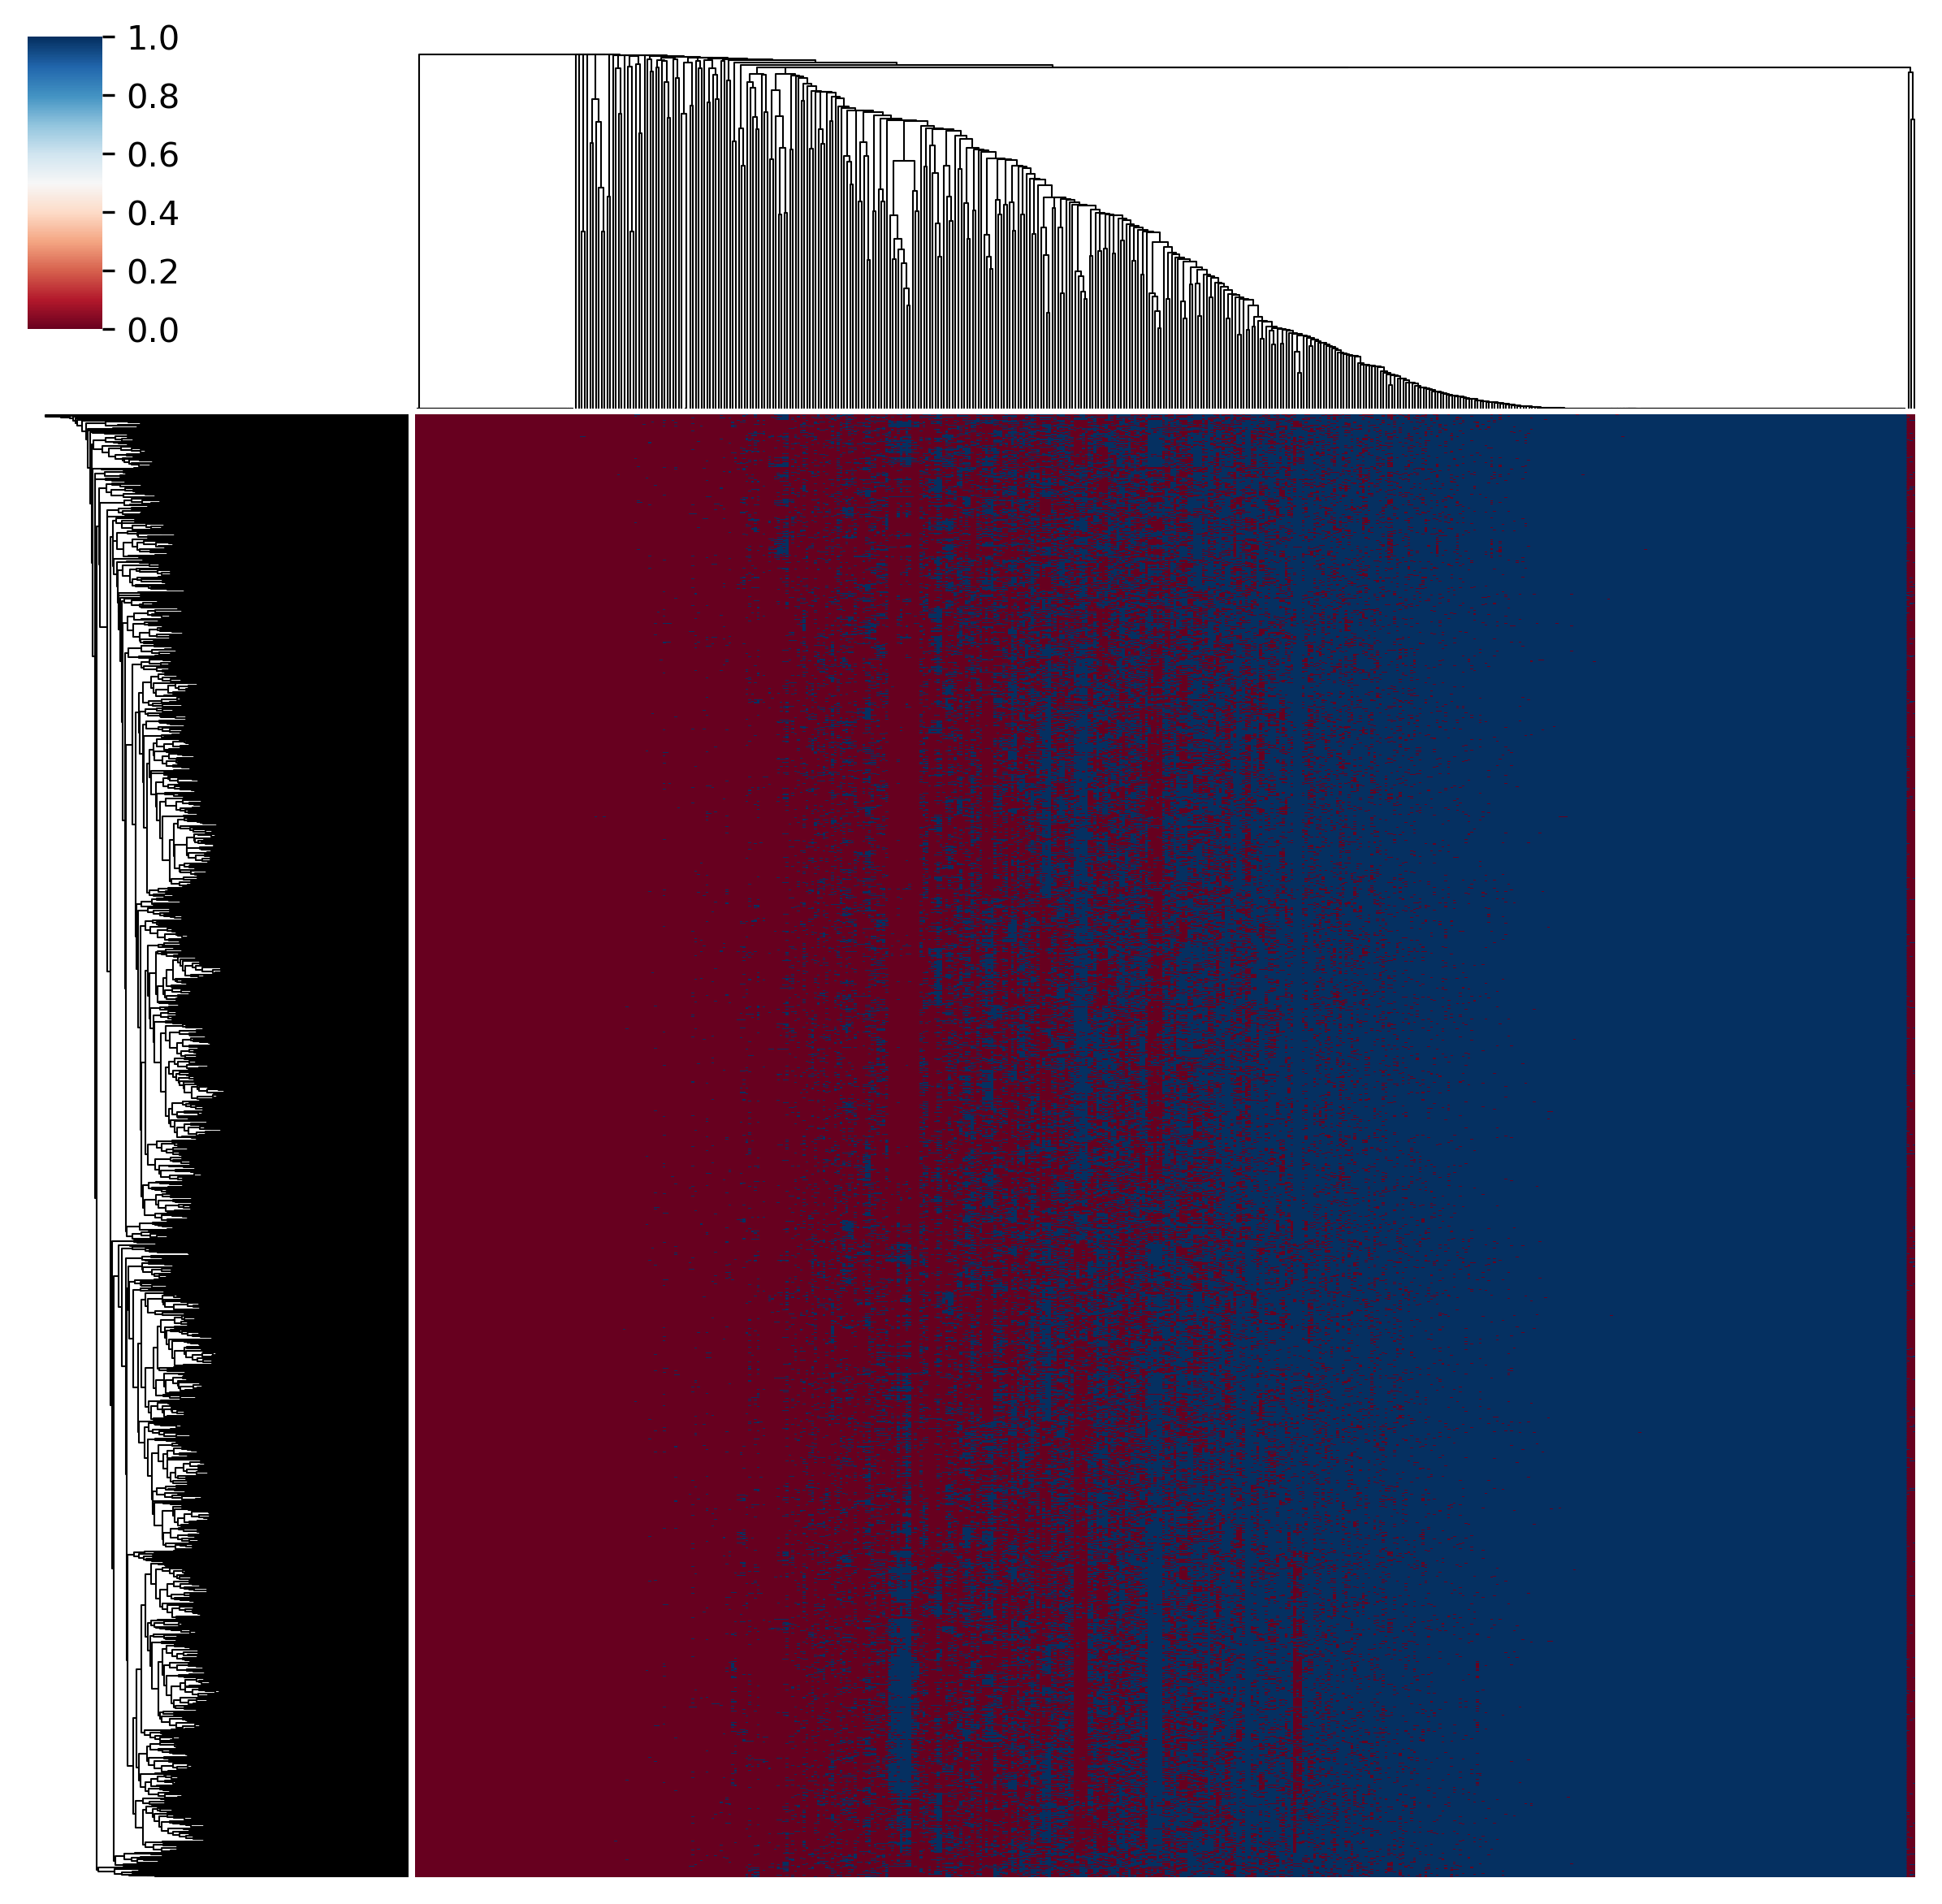

In [118]:
#linkage_col = hierarchy.linkage(compatibility_table.T, method='average', metric='jaccard')
#linkage_row = hierarchy.linkage(compatibility_table,   method='average', metric='jaccard')

clst_map = sns.clustermap(compatibility_table,
                          row_linkage=linkage_row,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)
#clst_map.fig.set_size_inches(10, 20)

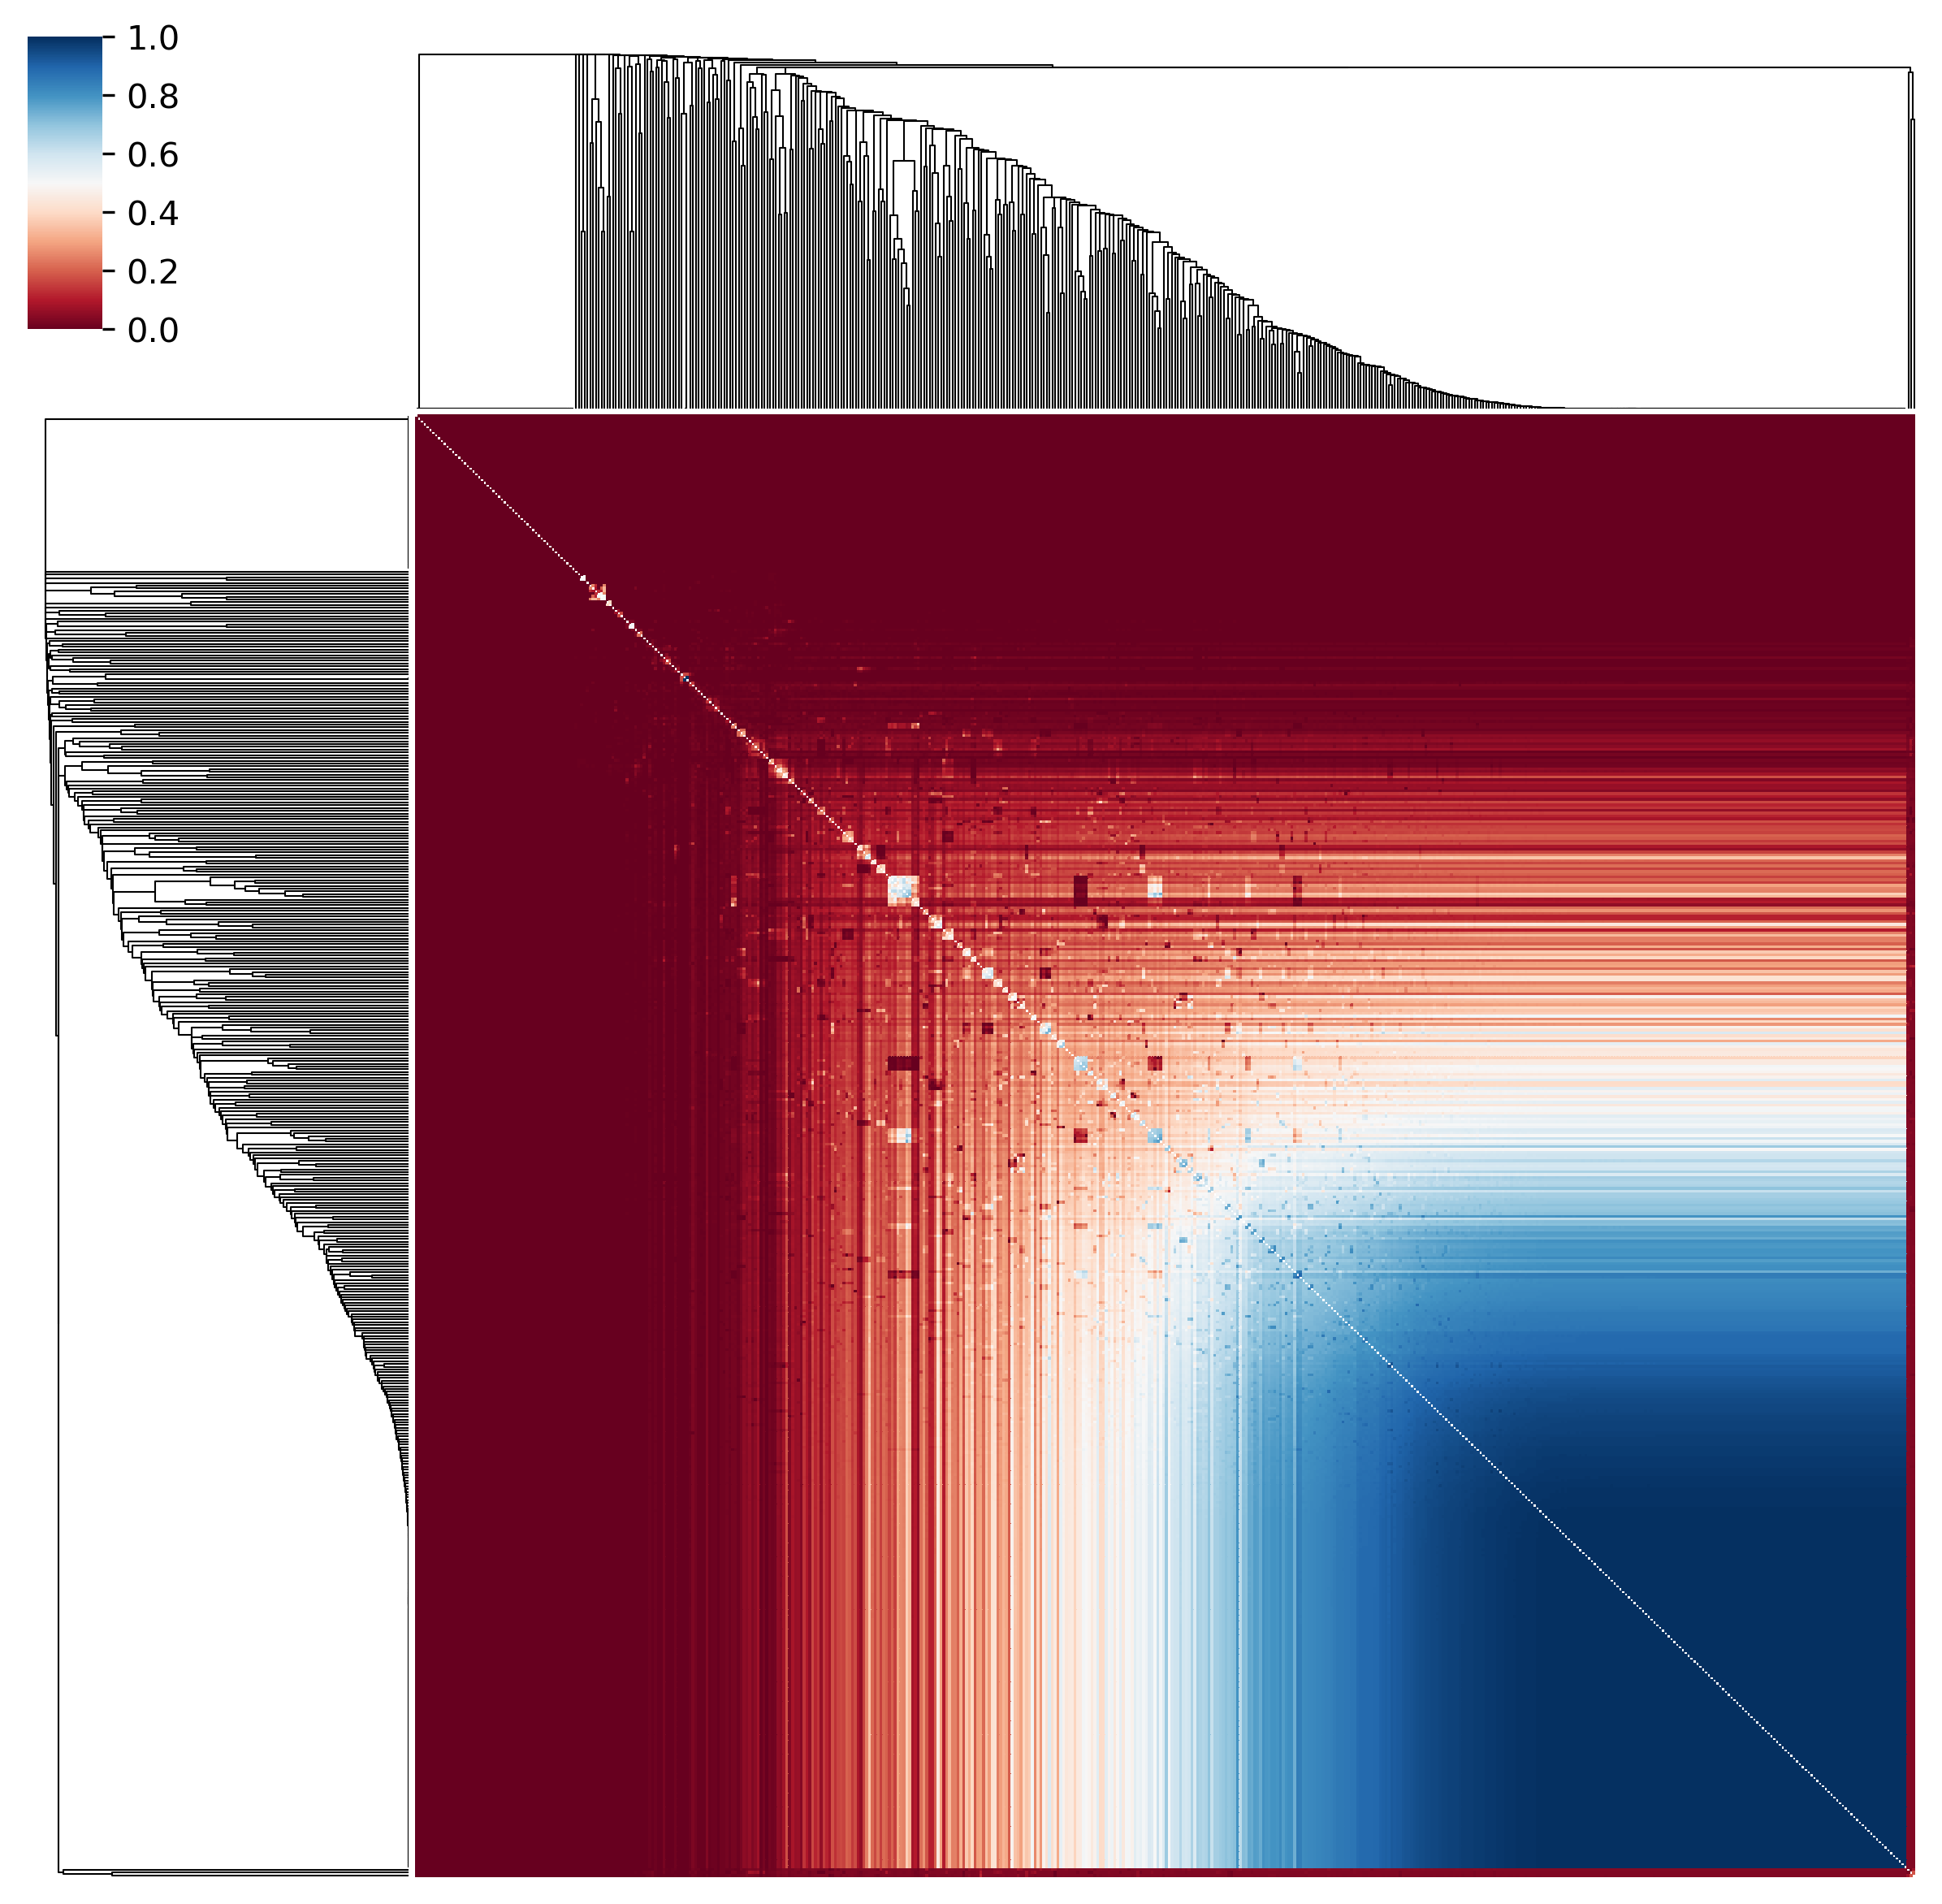

In [122]:
#linkage = hierarchy.linkage(1-condensed_distances, method='average', metric='precomputed')

tmp_df = jaccard_distances.copy()
np.fill_diagonal(tmp_df.values, np.nan)

clst_map = sns.clustermap(tmp_df,
                          row_linkage=linkage_col,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)

In [130]:
non_universal_constraints      = compatibility_count.index[compatibility_count/len(posterior_trees) < 0.95]
restricted_compatibility_table = compatibility_table.reindex(columns=non_universal_constraints)

linkage_col = hierarchy.linkage(restricted_compatibility_table.T, method='average', metric='jaccard')
linkage_row = hierarchy.linkage(restricted_compatibility_table,   method='average', metric='jaccard')

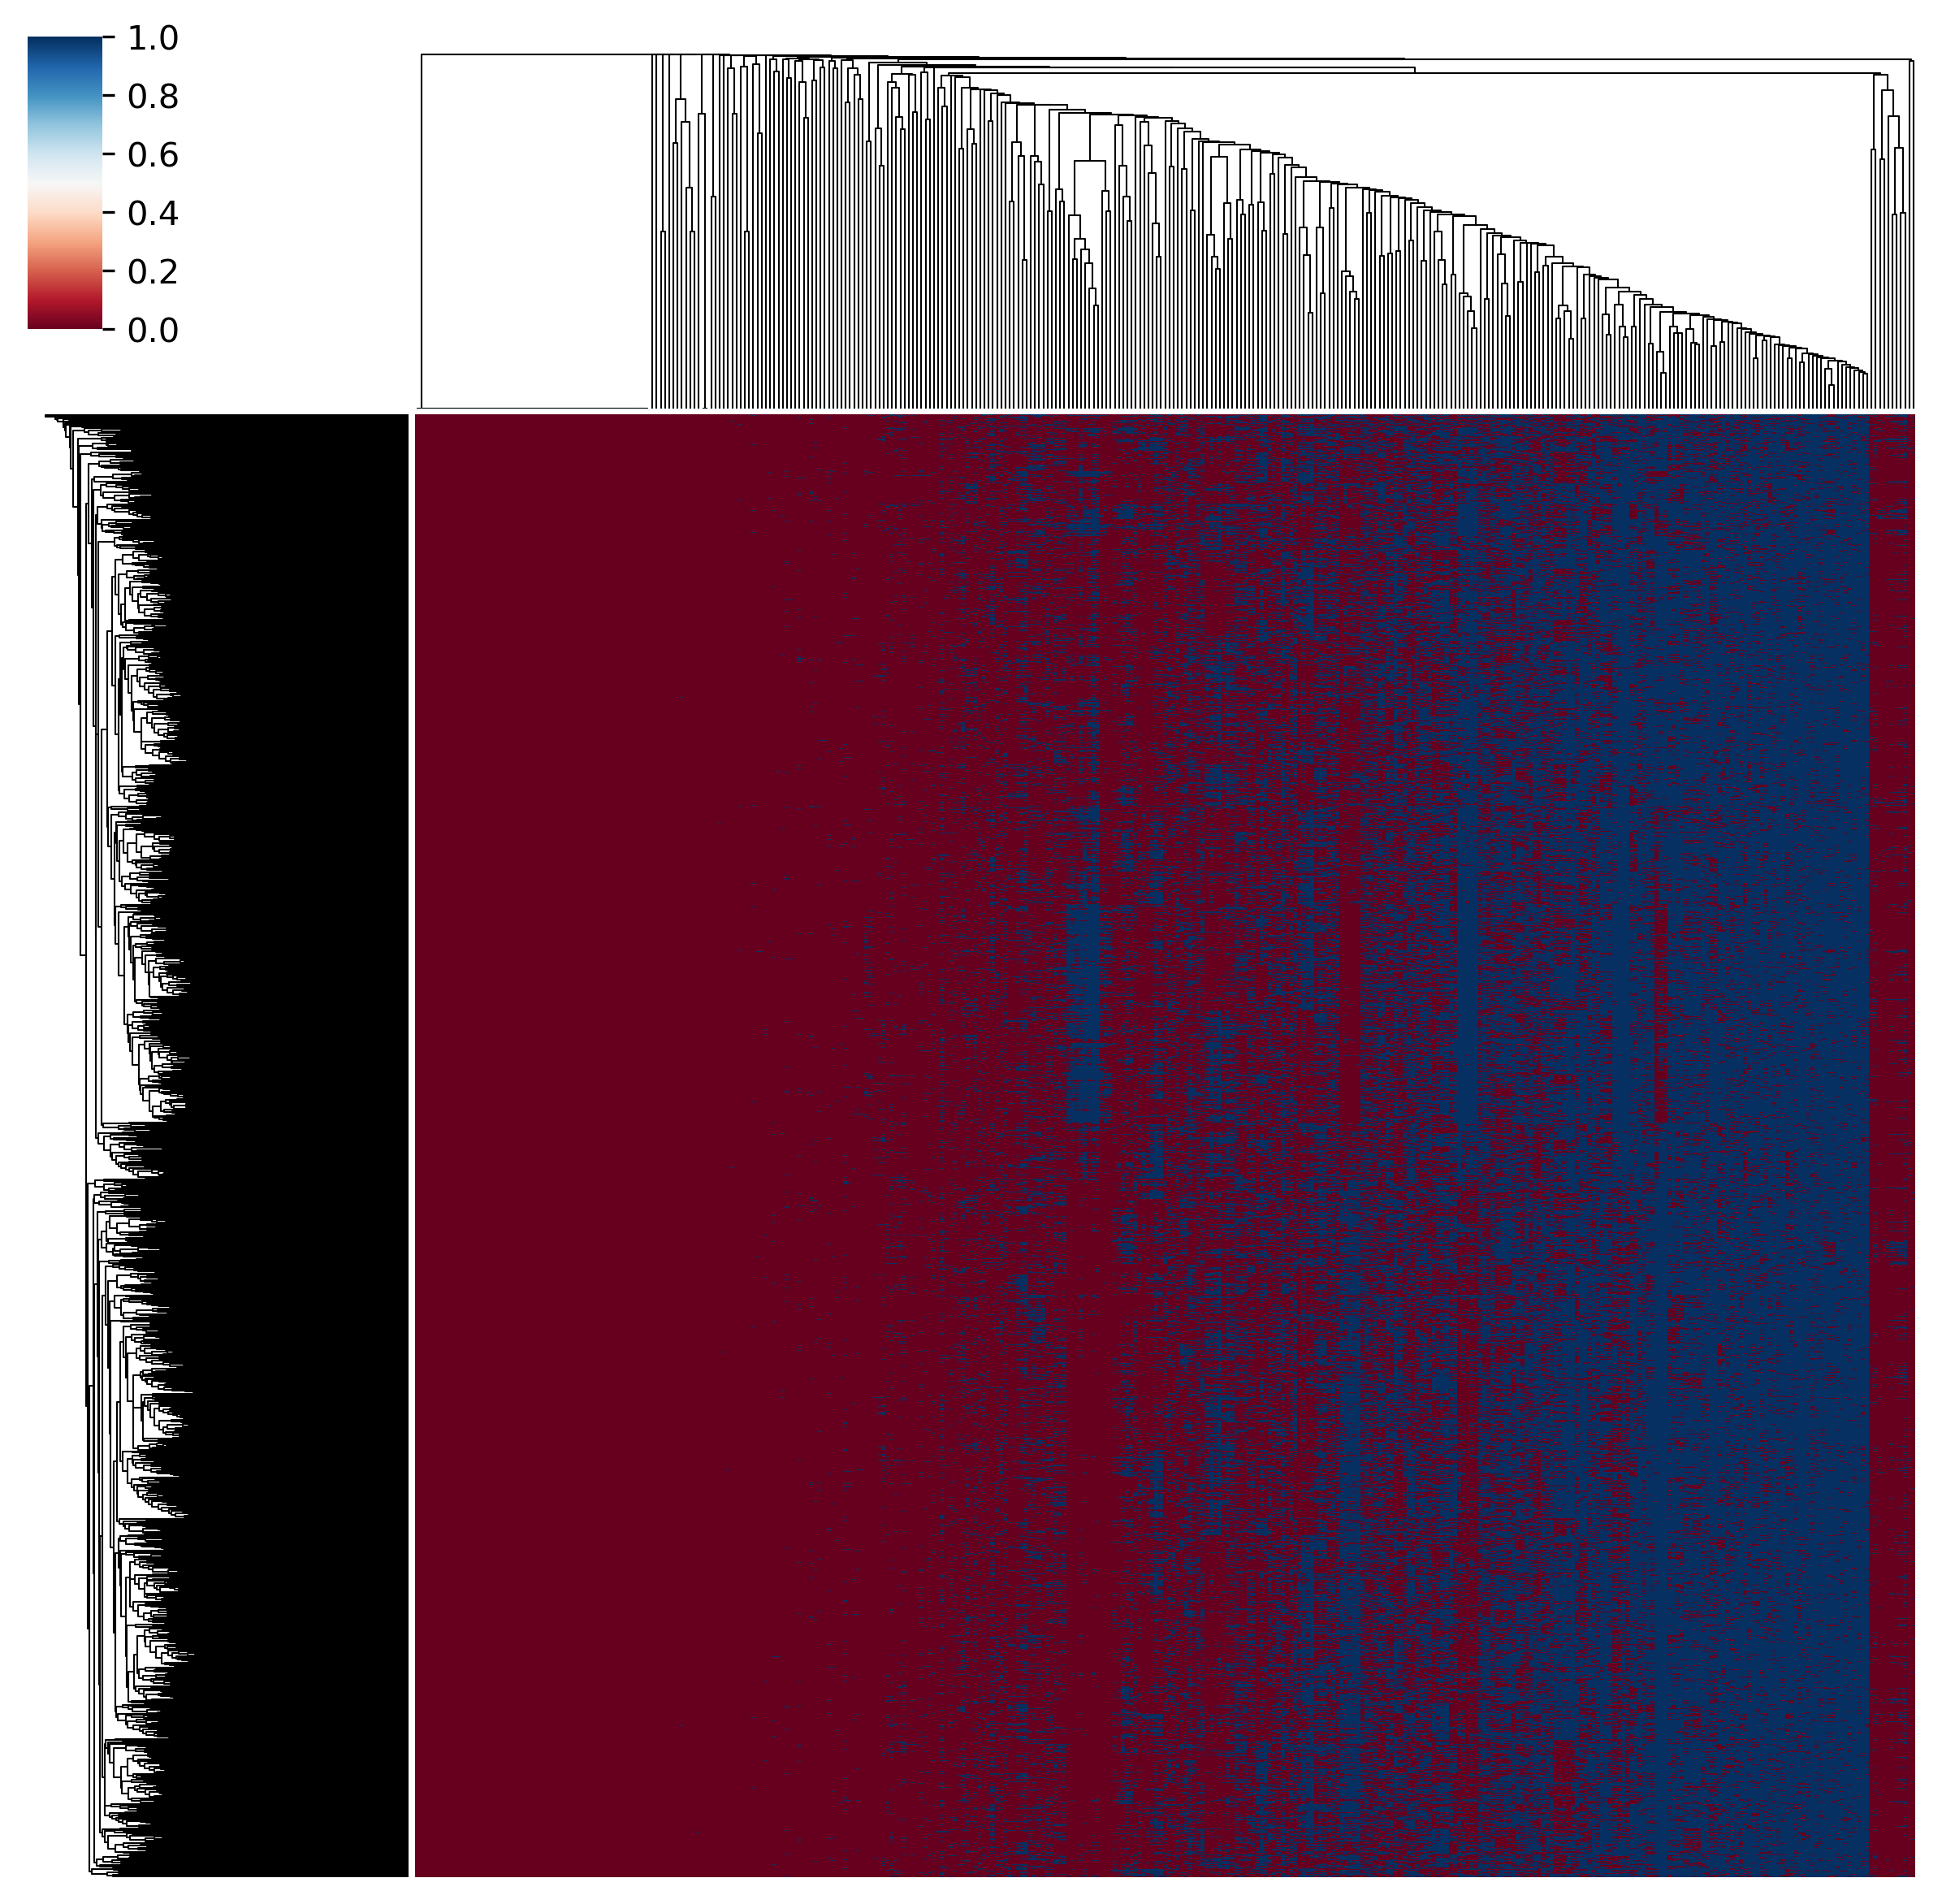

In [131]:
clst_map = sns.clustermap(restricted_compatibility_table,
                          row_linkage=linkage_row,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)

In [136]:
non_universal_jaccard_distances = jaccard_distances.reindex(index  =non_universal_constraints,
                                                            columns=non_universal_constraints,
                                                            copy   =True)

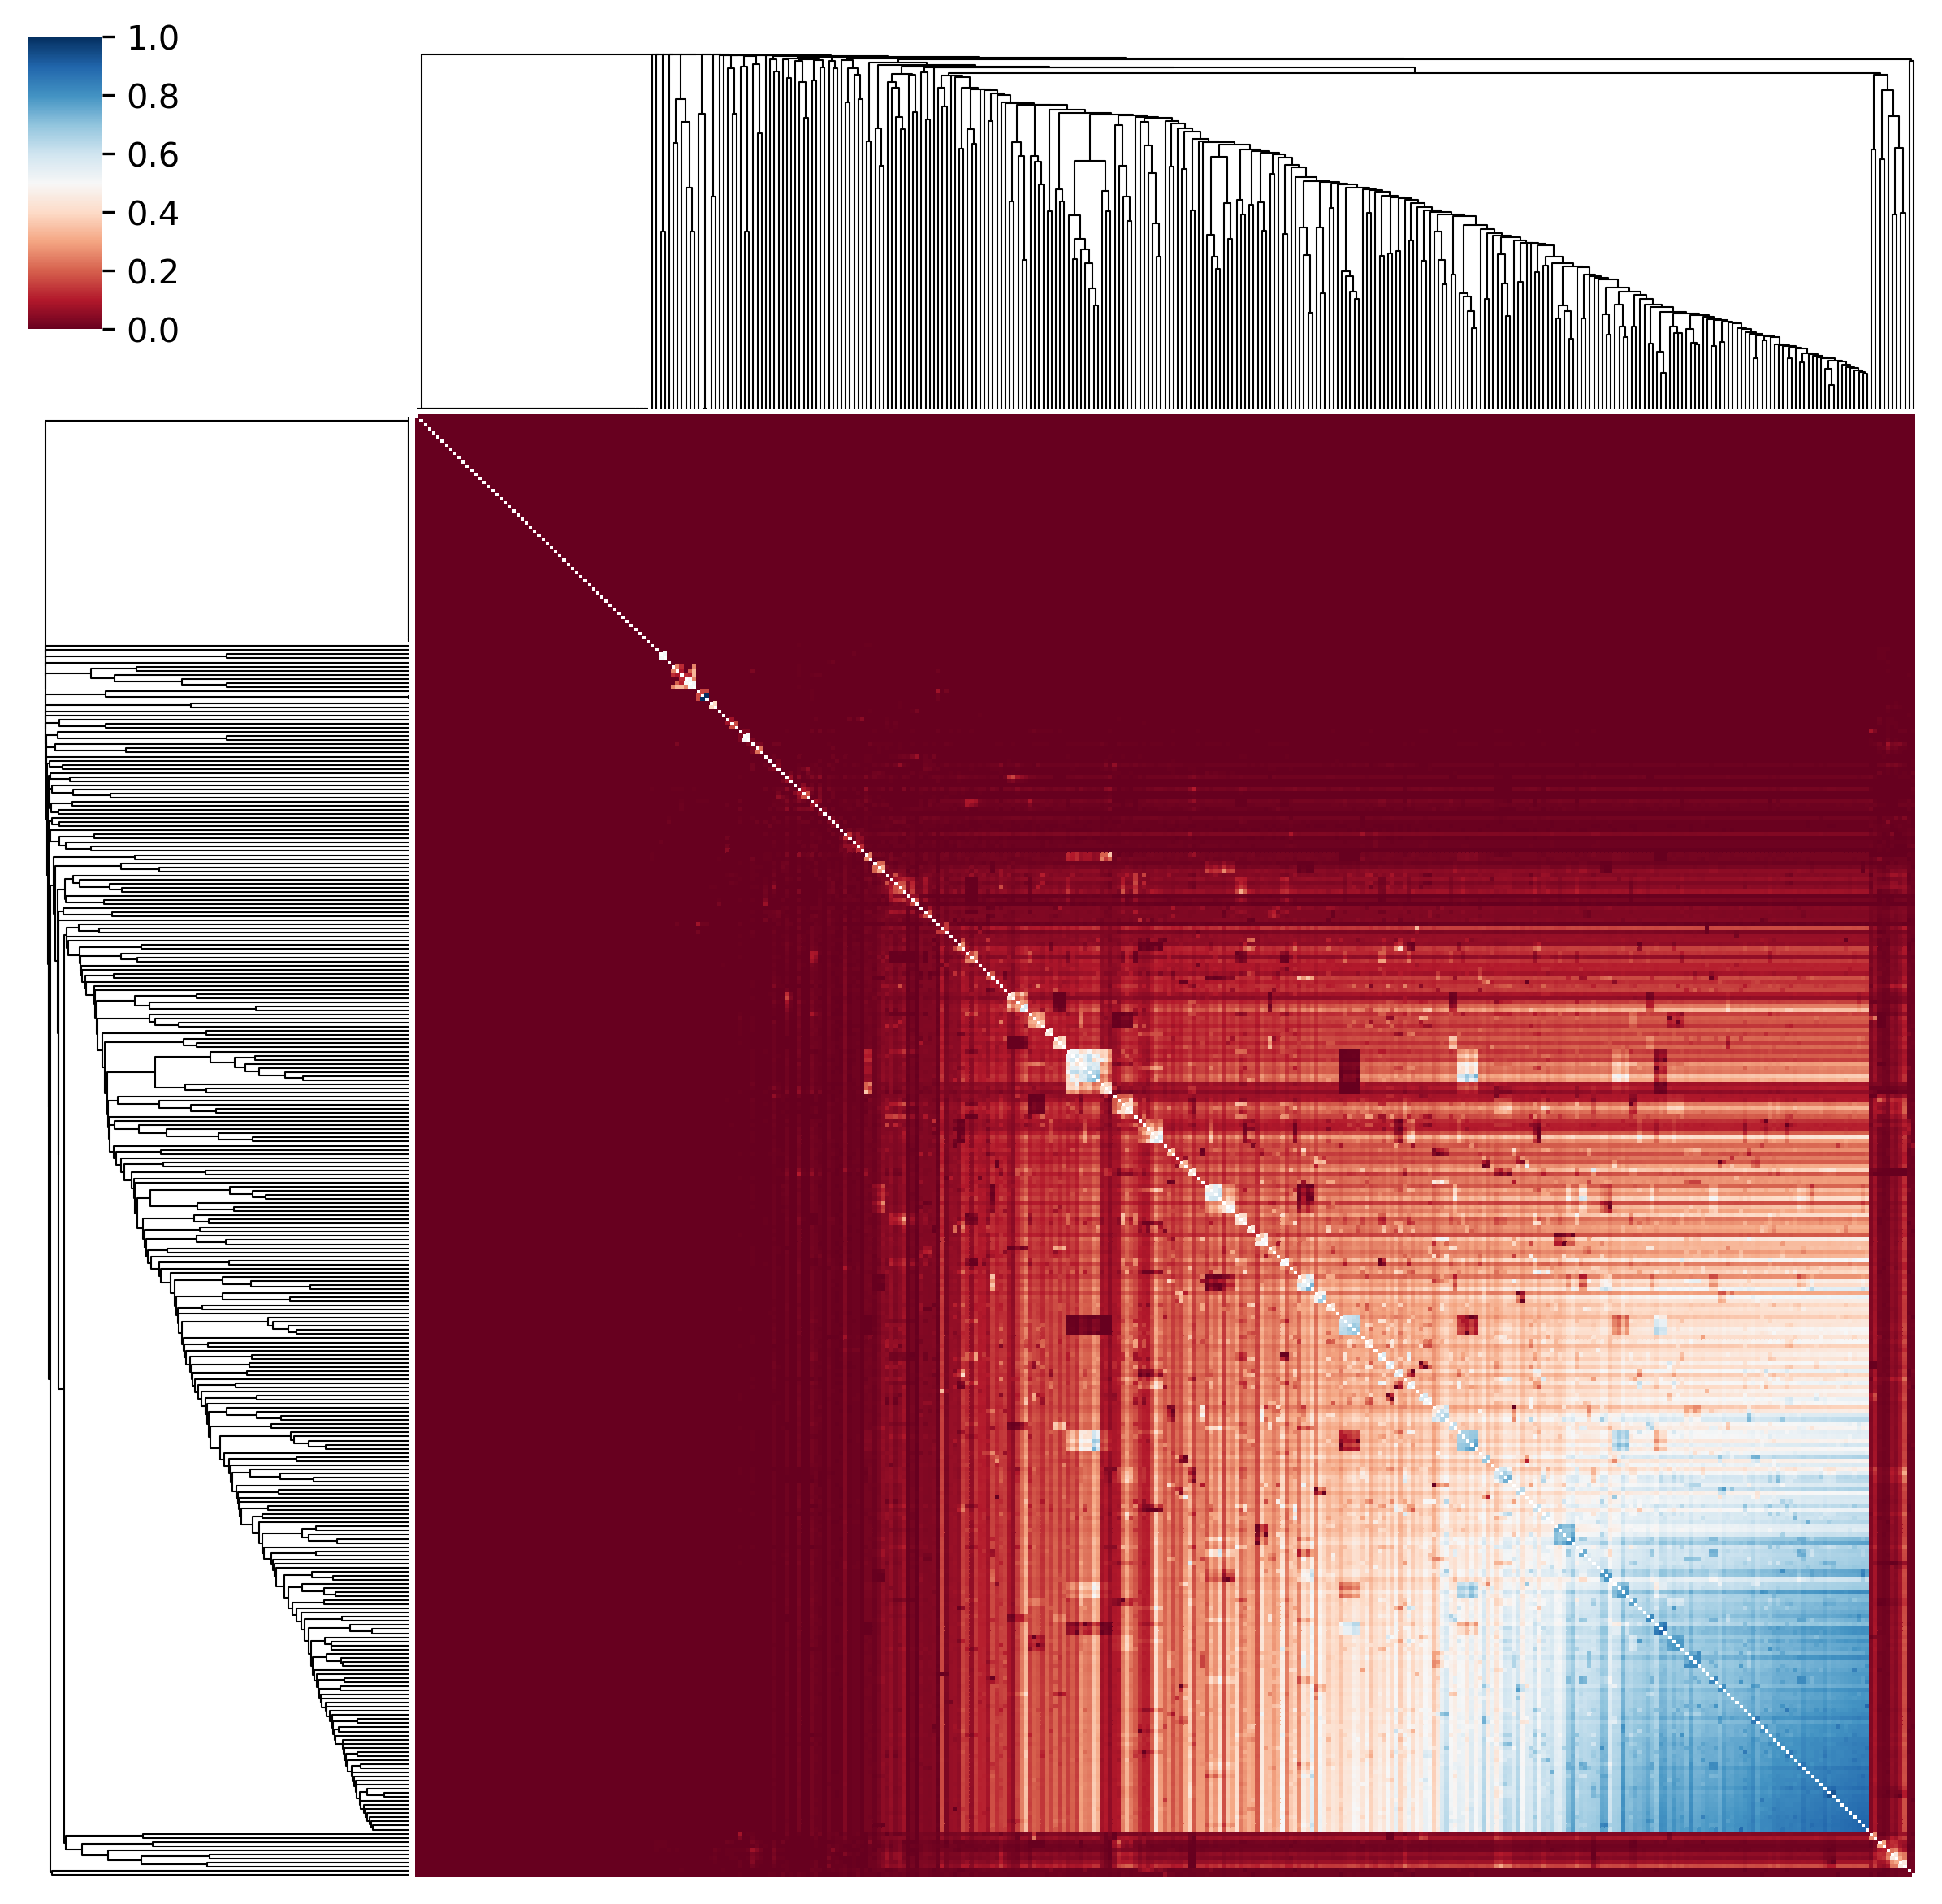

In [139]:
linkage = hierarchy.linkage(1-squareform(non_universal_jaccard_distances), 
                            method='average',
                            metric='precomputed')

tmp_df = non_universal_jaccard_distances.copy()
np.fill_diagonal(tmp_df.values, np.nan)

clst_map = sns.clustermap(tmp_df,
                          row_linkage=linkage_col,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)

In [96]:
tmp_df = 1-jaccard_distances
np.fill_diagonal(tmp_df.values, 0)

mds = manifold.MDS(n_components=2,
                   dissimilarity='precomputed',
                   random_state=12345)
mds_result = mds.fit(tmp_df)

coords     = mds_result.embedding_
constraintX, constraintY = coords[:, 0], coords[:, 1]

In [98]:
tmp_df         = jaccard_distances.copy()
tmp_df.index   = range(jaccard_distances.shape[0])
tmp_df.columns = range(jaccard_distances.shape[0])

In [141]:
tmp_df = 1-non_universal_jaccard_distances
np.fill_diagonal(tmp_df.values, 0)

mds = manifold.MDS(n_components=2,
                   dissimilarity='precomputed',
                   random_state=12345)
mds_result = mds.fit(tmp_df)

coords     = mds_result.embedding_
constraintX, constraintY = coords[:, 0], coords[:, 1]

In [143]:
tmp_df         = non_universal_jaccard_distances.copy()
tmp_df.index   = range(non_universal_jaccard_distances.shape[0])
tmp_df.columns = range(non_universal_jaccard_distances.shape[0])

In [144]:
graph   = nx.convert_matrix.from_pandas_adjacency(tmp_df)
louvain = community.best_partition(graph, random_state=12345)

In [146]:
clusters = []
for count, constraint in enumerate(non_universal_constraints):
    clusters.append(louvain[count])

cluster_frequencies     = dict(collections.Counter(clusters))
clusters_sorted_by_size = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

In [148]:
cluster_coords                 = pd.DataFrame(columns='x y cluster'.split(), 
                                              data=zip(constraintX,constraintY, clusters))
cluster_coords['cluster_size'] = [cluster_frequencies[cluster]
                                  for cluster in cluster_coords.cluster]
cluster_coords.loc[cluster_coords.cluster_size<3, 'cluster'] = 'none'

cluster_coords.index = non_universal_constraints
cluster_coords       = cluster_coords.join(compatibility_count)

constraint_supports = {constraint:len(indexes)
                       for constraint, indexes in transfer_df.groupby(['donor', 'recipient']).groups.items()}
cluster_coords      = cluster_coords.join(
    pd.DataFrame.from_dict([constraint_supports]).T
)
cluster_coords.rename(columns={0:'constraint_support'}, inplace=True)

constraint_distance = [tree.get_distance(node1, node2)
                      for node1, node2 in cluster_coords.index]
cluster_coords['constraint_distance'] = constraint_distance

In [109]:
cluster_coords[cluster_coords.cluster==0].shape

(55, 8)

In [102]:
constrained_families = []
for donor, recipient in cluster_coords.index:
    tmp = transfer_df.loc[(transfer_df.donor==donor) &
                          (transfer_df.recipient==recipient),
                          'family']
    constrained_families.append(';'.join(tmp.values))
cluster_coords['constrained_families'] = constrained_families

In [44]:
cluster_coords.to_csv('constraint_clusters-BB.tab', sep='\t')

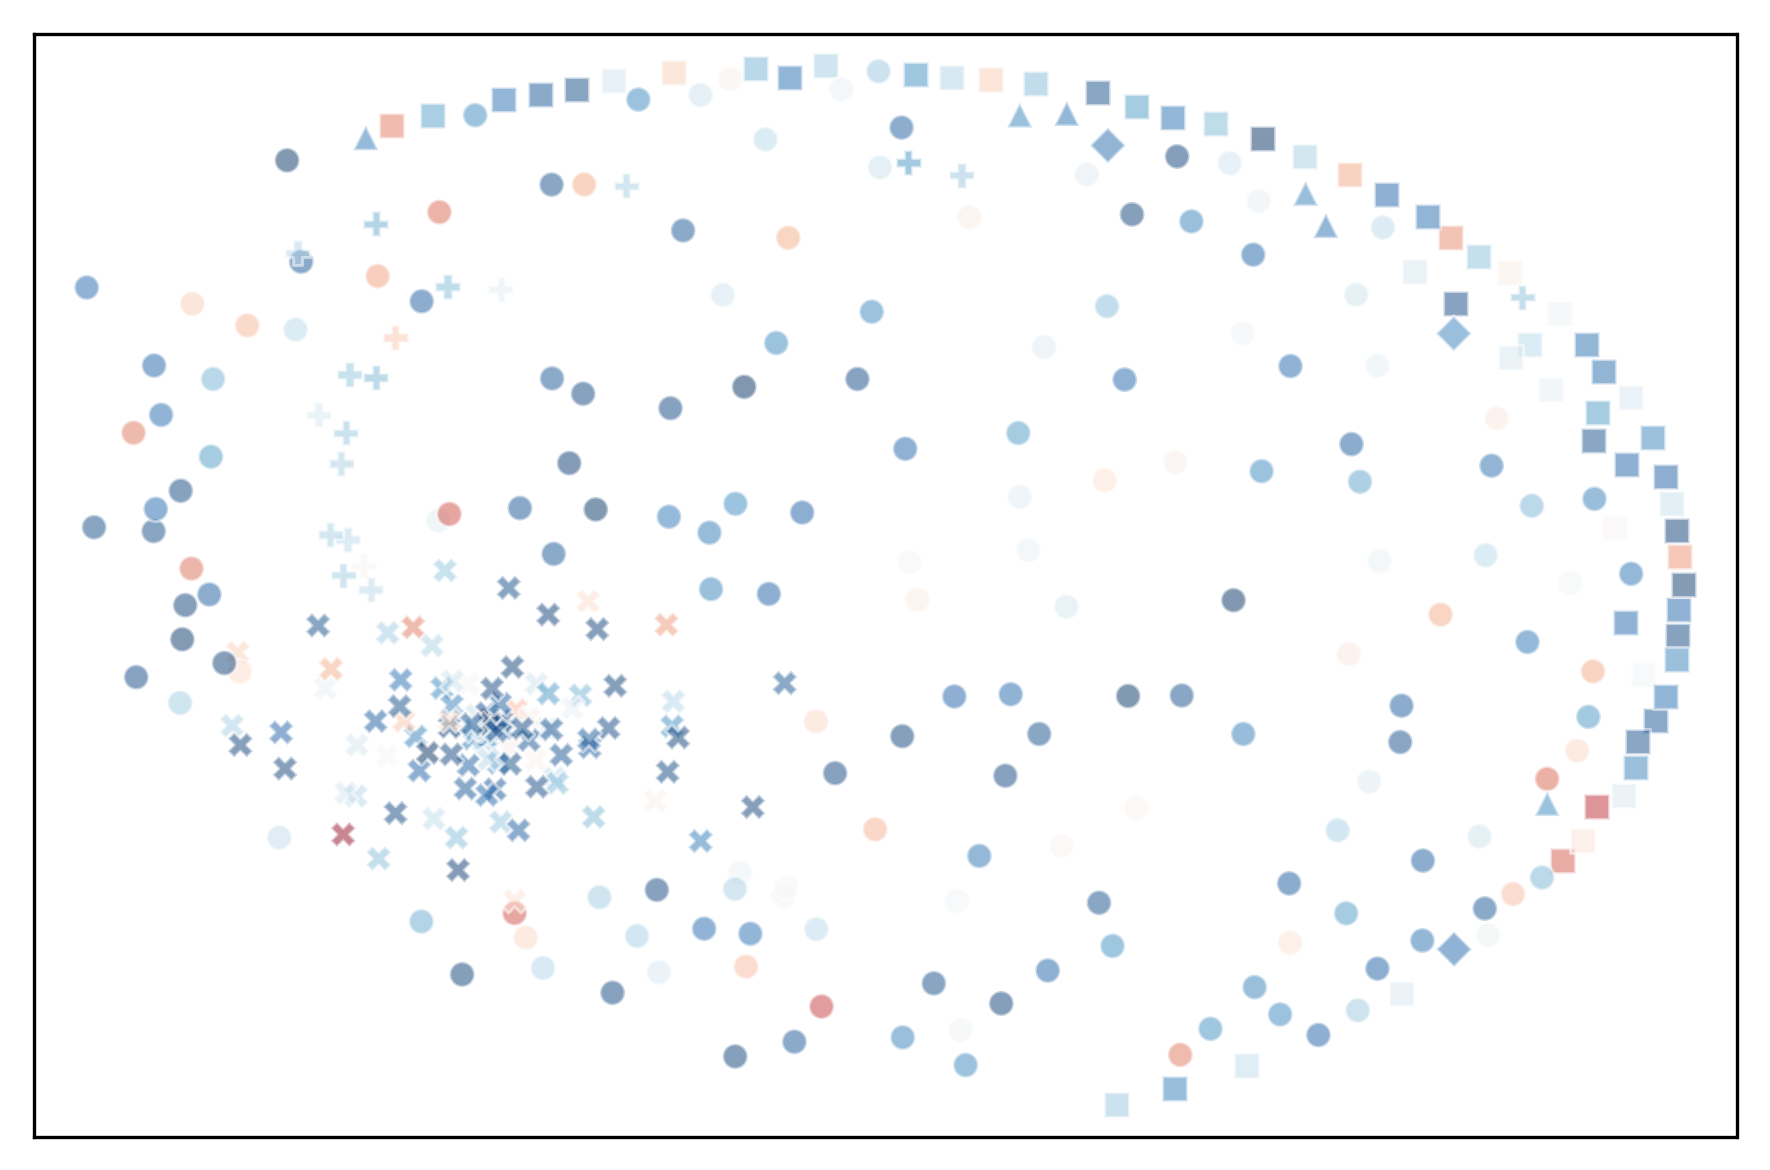

In [152]:
fig, ax = plt.subplots()

yeah = sns.scatterplot(x='x', 
                y='y',
                style='cluster',
                hue='constraint_distance',
                palette='RdBu_r',
                data=cluster_coords,
                alpha=0.5,
#                size='compatibility_count',
#                color='black',
                legend=False,
                ax=ax,
                      cmap=plt.cm.get_cmap('cubehelix', 6));

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)

#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

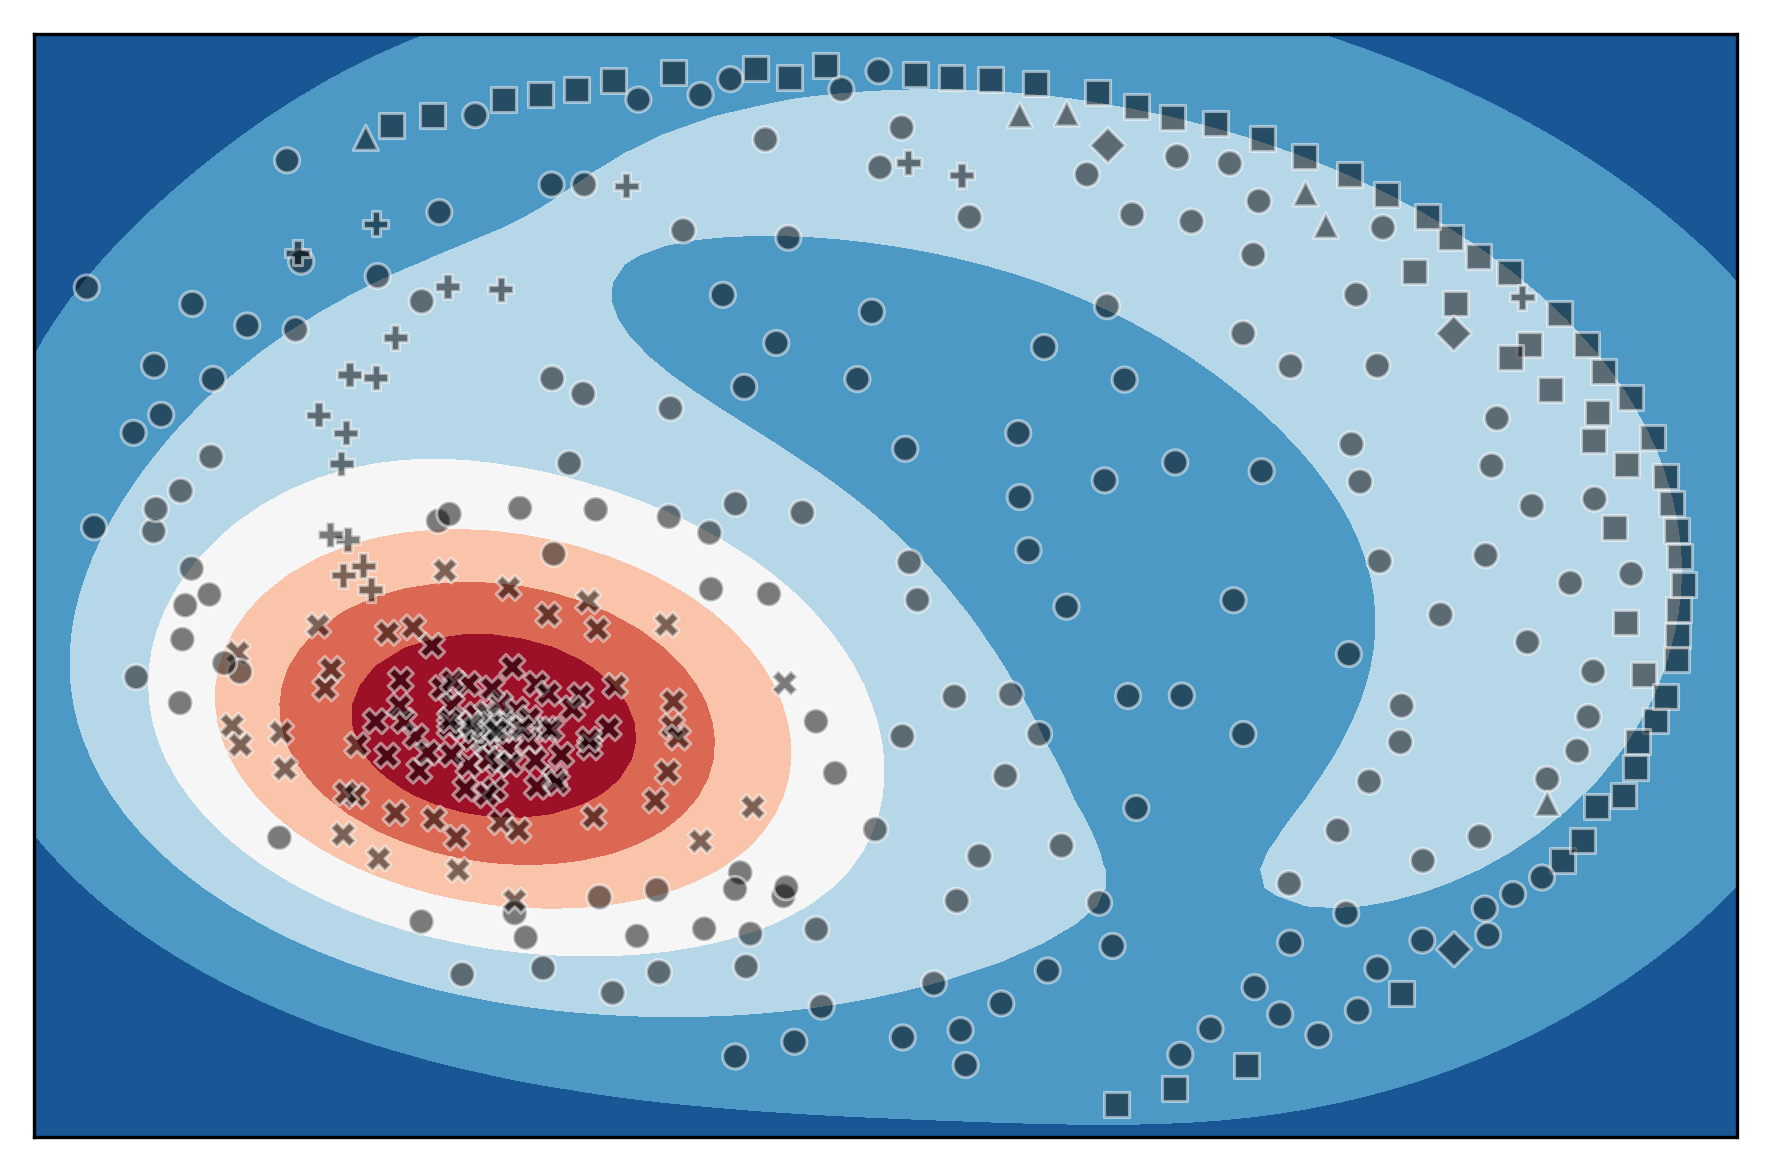

In [150]:
fig, ax = plt.subplots()

sns.kdeplot(constraintX, 
            constraintY,
            bw=0.2,
            n_levels=9,
            cmap='RdBu_r',
            shade=True,
            ax=ax,
           )

sns.scatterplot(x='x', 
                y='y',
                style='cluster',
#                hue='constraint_distance',
#                palette='RdBu_r',
                data=cluster_coords,
                alpha=0.5,
#                size='compatibility_count',
                color='black',
                legend=False,
                ax=ax);

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)
#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

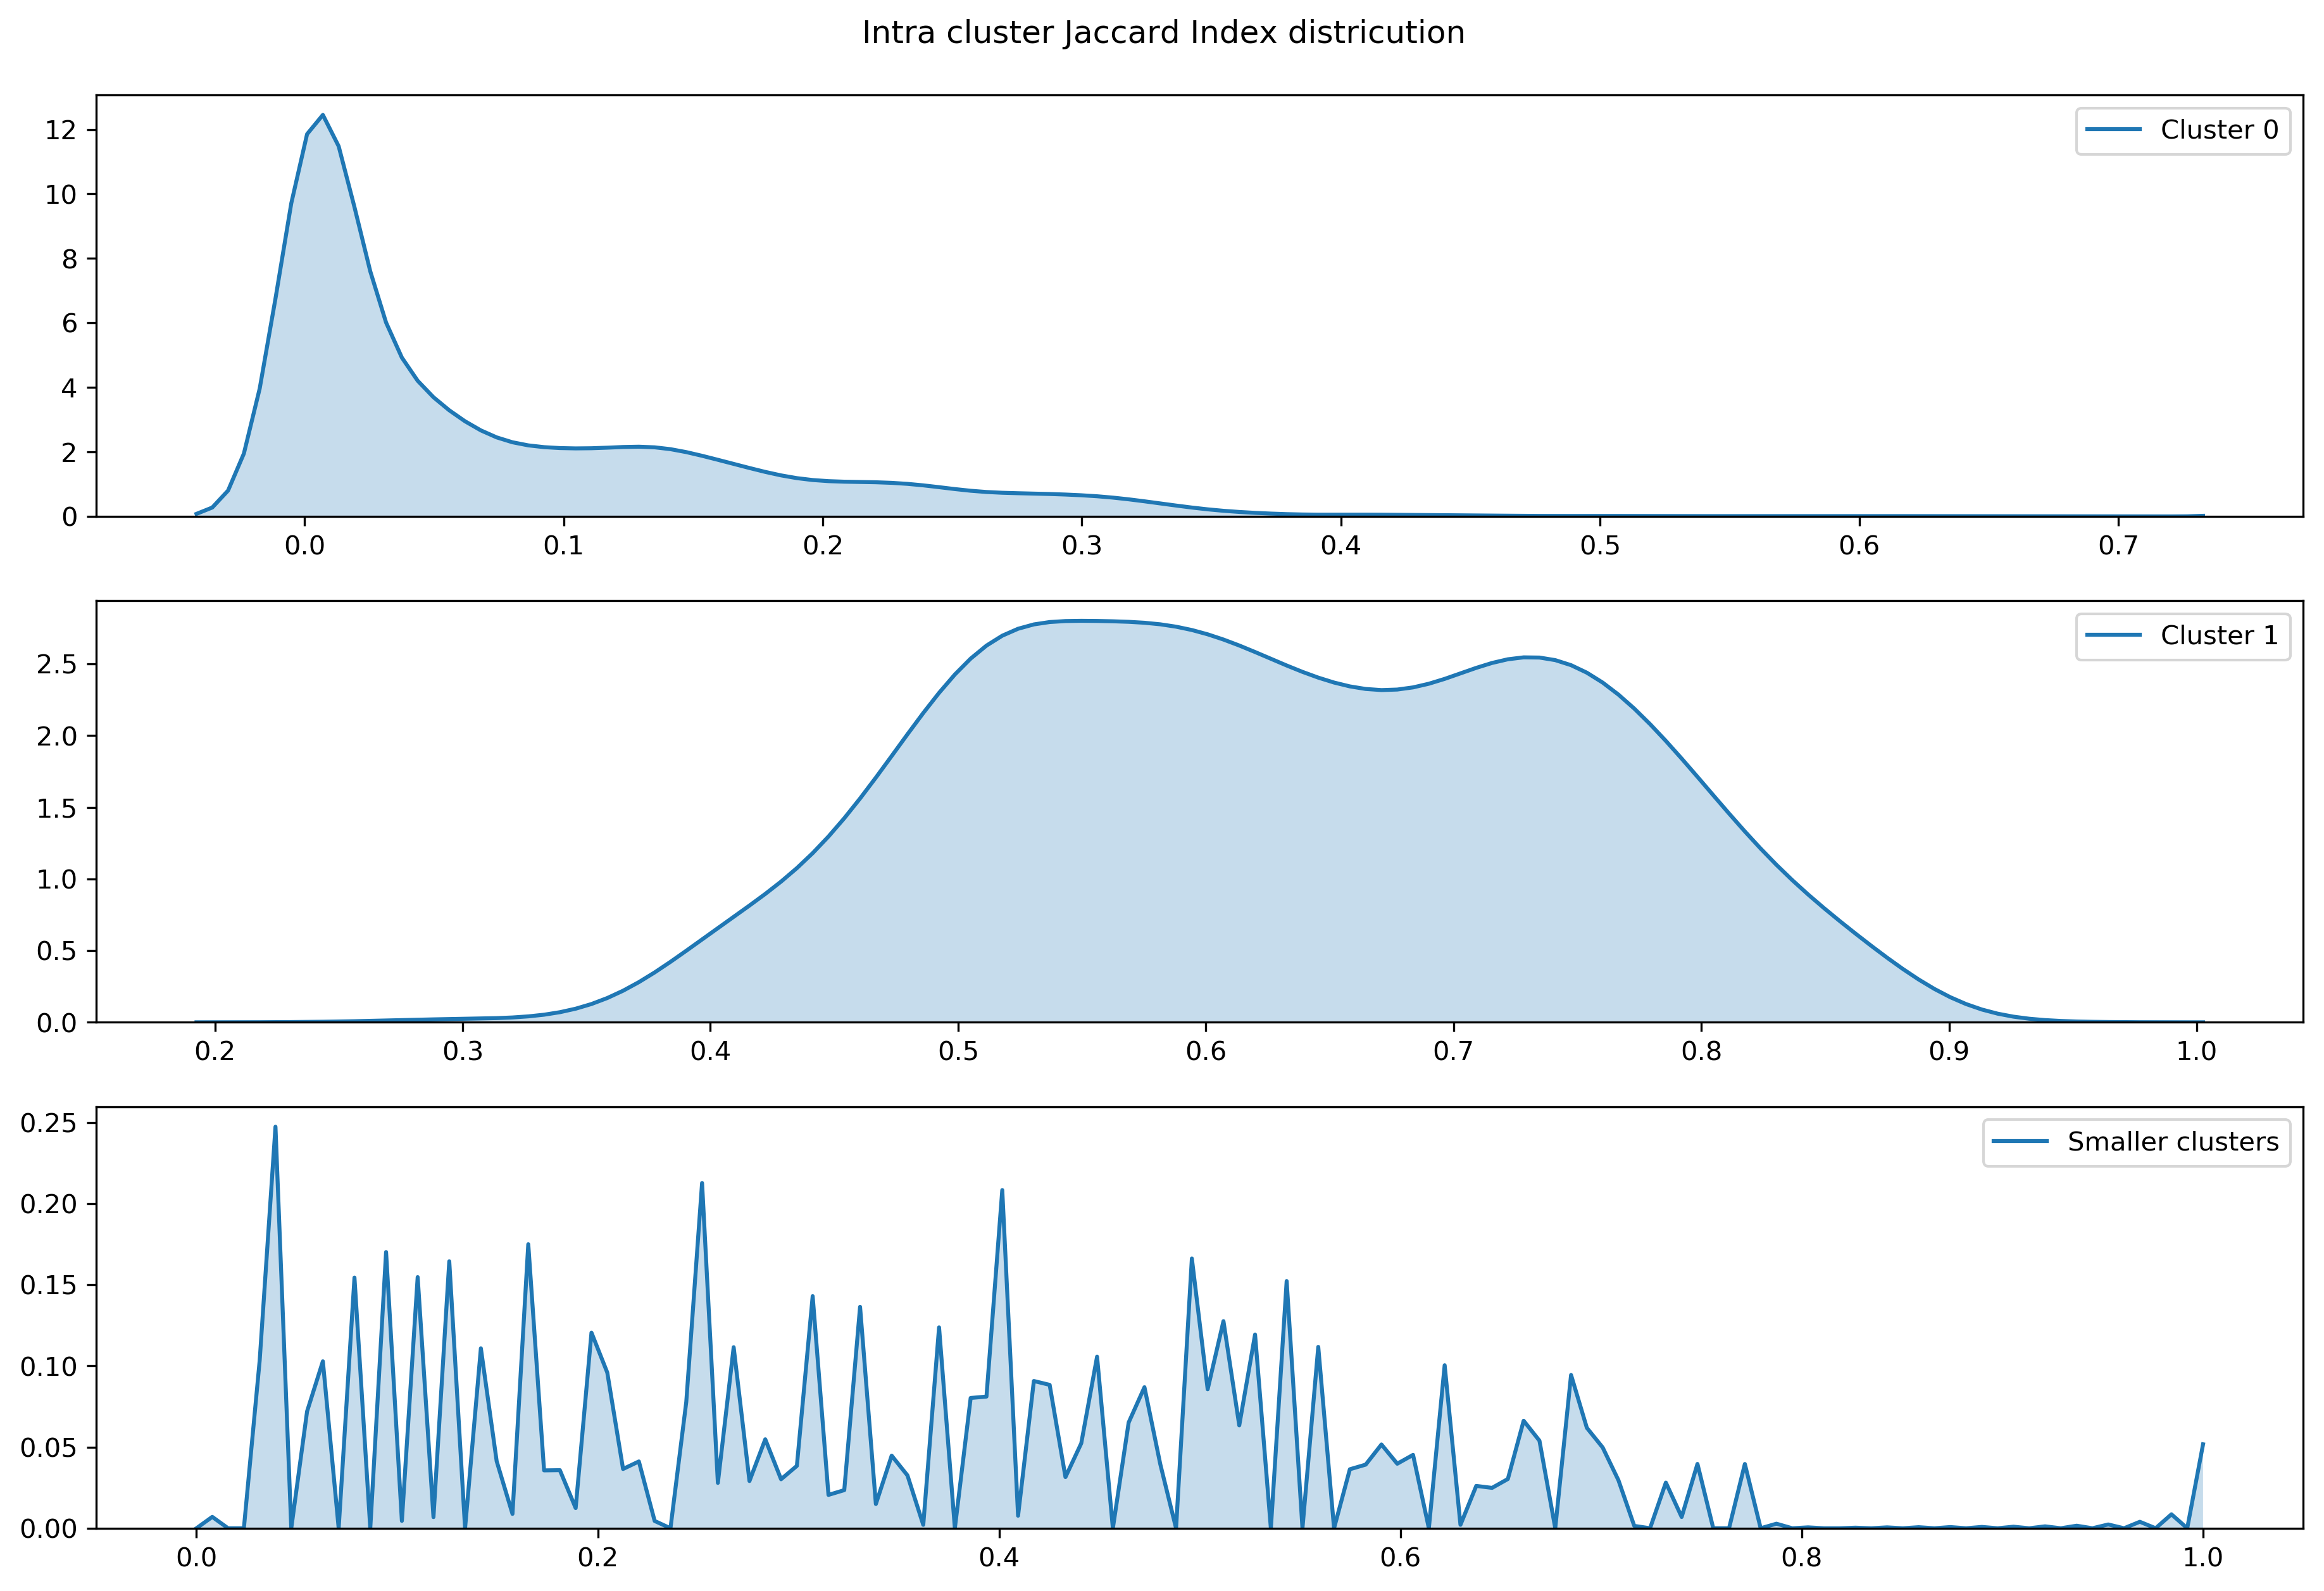

In [151]:
fig, axs = plt.subplots(nrows=3, figsize=(15,10))
for cluster_num, ax in zip([0, 1], axs):
    tmp = cluster_coords.index[cluster_coords.cluster==cluster_num]
    tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
    sns.kdeplot(tmp_condensed, shade=True, ax=ax, label='Cluster %i' % cluster_num)

tmp           = cluster_coords.index[(cluster_coords.cluster!=0) &
                                     (cluster_coords.cluster!=1)]
tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
sns.kdeplot(tmp_condensed, shade=True, ax=axs[2], label='Smaller clusters')
fig.suptitle('Intra cluster Jaccard Index districution', y=0.92)
fig.set_dpi(300)

In [171]:
cluster0               = set(cluster_coords.query('cluster==1').index.tolist())
cluster0_compatibility = compatibility_table[cluster0]

num_trees, num_constraints = cluster0_compatibility.shape
num_compatibles            = cluster0_compatibility.T.sum()

x = np.linspace(54, num_constraints*.94, 10)
y = []
target_node_ages = {'n8':[],
                    'n117':[],
                    'n159':[]}
target_node_descendants = {}
for node_name in target_node_ages:
    node = next(tree.iter_search_nodes(name=node_name))
    target_node_descendants[node_name] = node.get_leaf_names()

for thresh in x:
    compatible_trees = num_compatibles[num_compatibles >= thresh].index
    y.append(len(compatible_trees)/num_trees)

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])
    
    for tree_index, target_node in itertools.product(compatible_trees, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                posterior_trees[tree_index],
                target_node_descendants[target_node]
            )
        )
y = np.array(y)

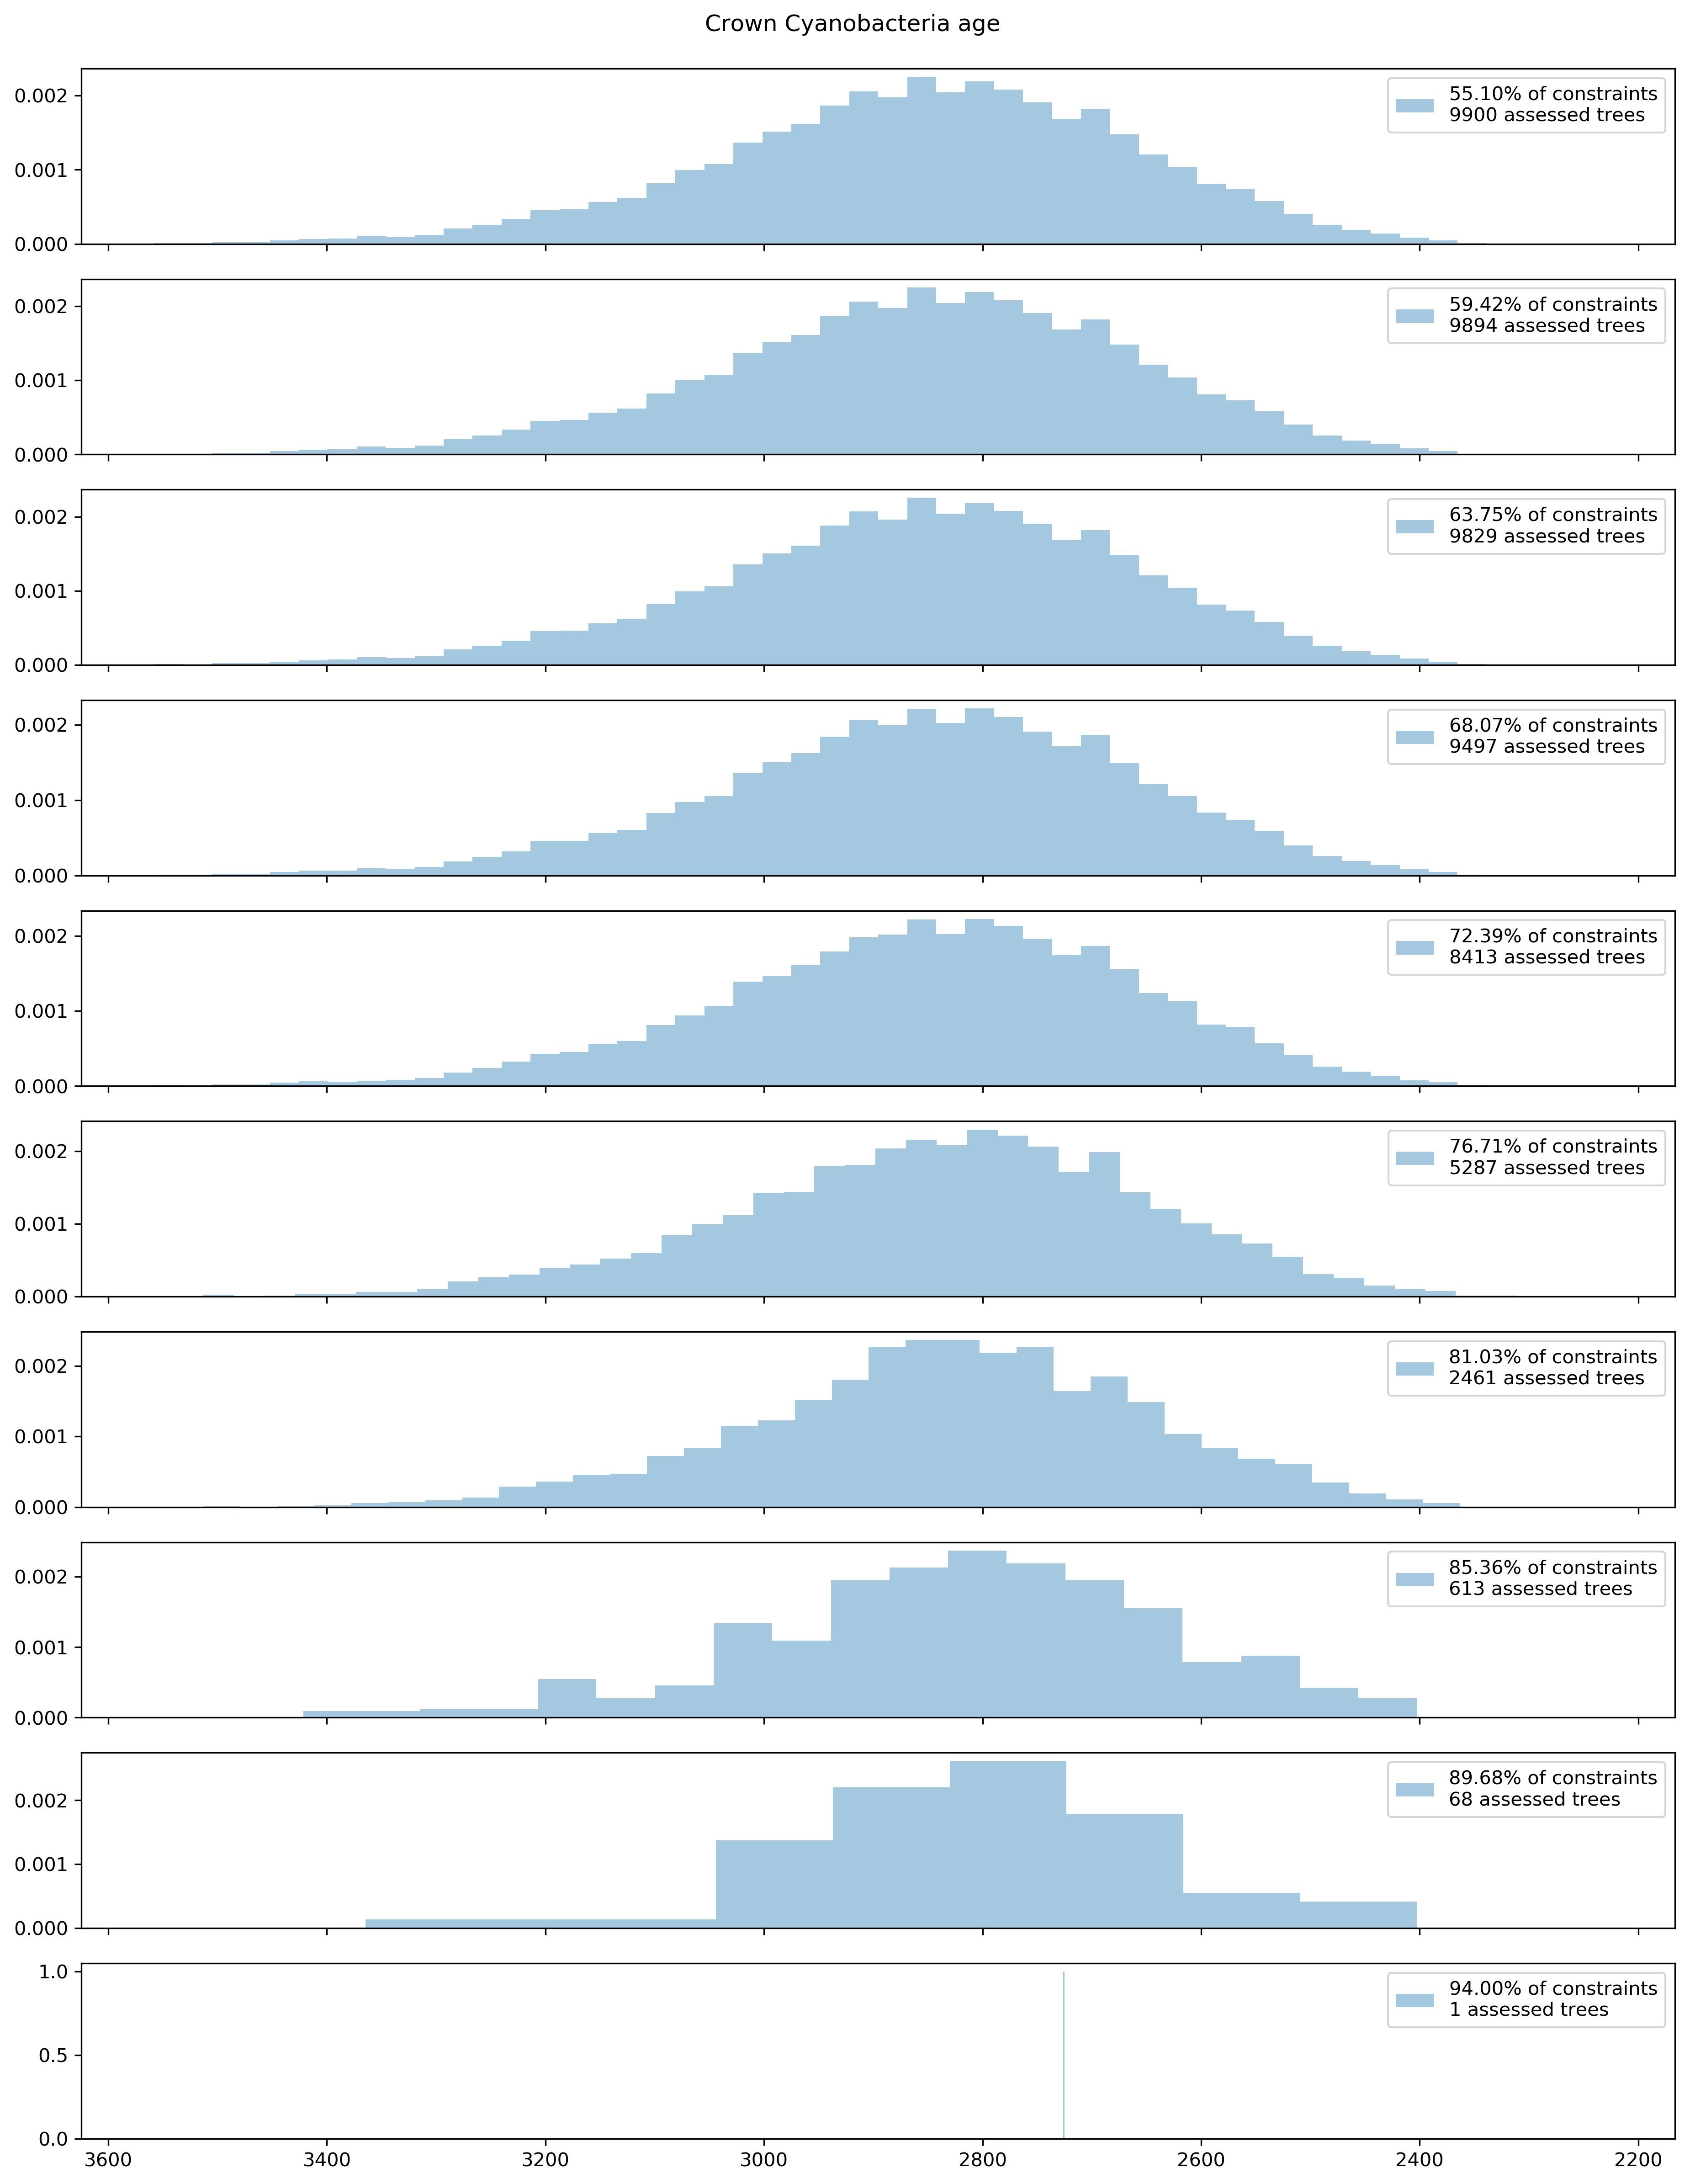

In [172]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n8']),
                        sharex=True)

fig.suptitle('Crown Cyanobacteria age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n8'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.legend()
ax.invert_xaxis()

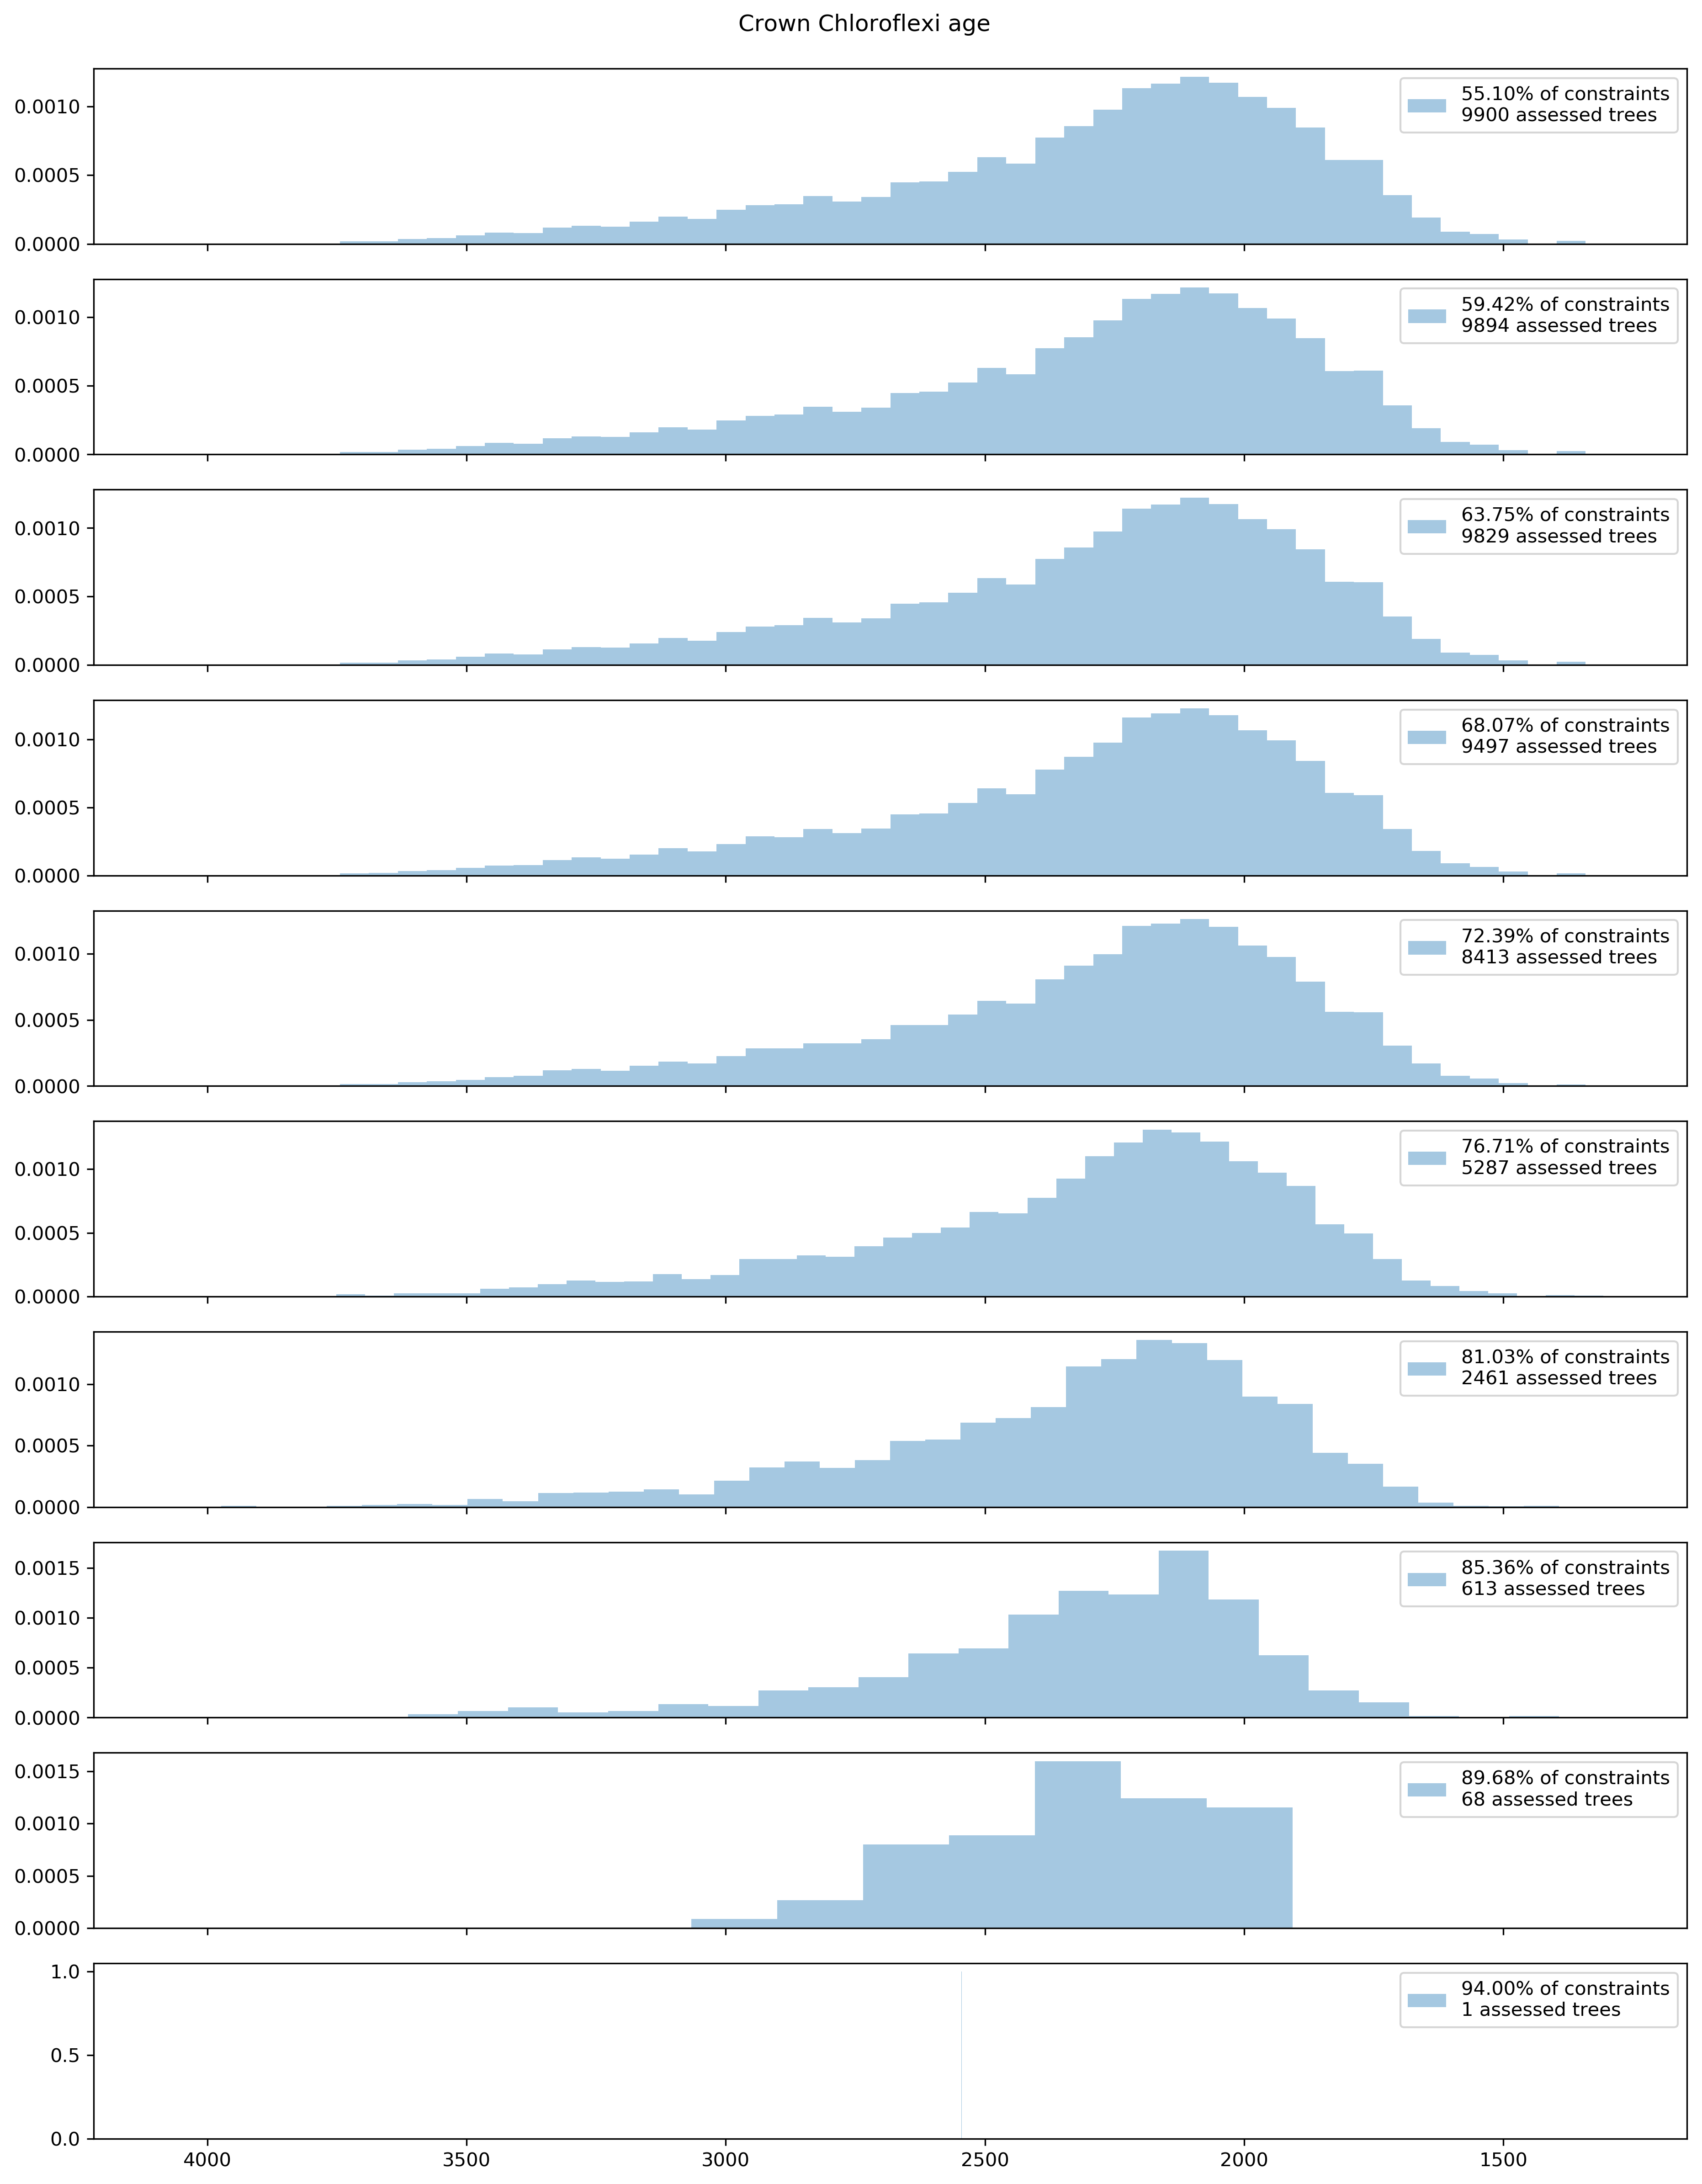

In [173]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n117']),
                        sharex=True)

fig.suptitle('Crown Chloroflexi age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n117'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.legend()
ax.invert_xaxis()

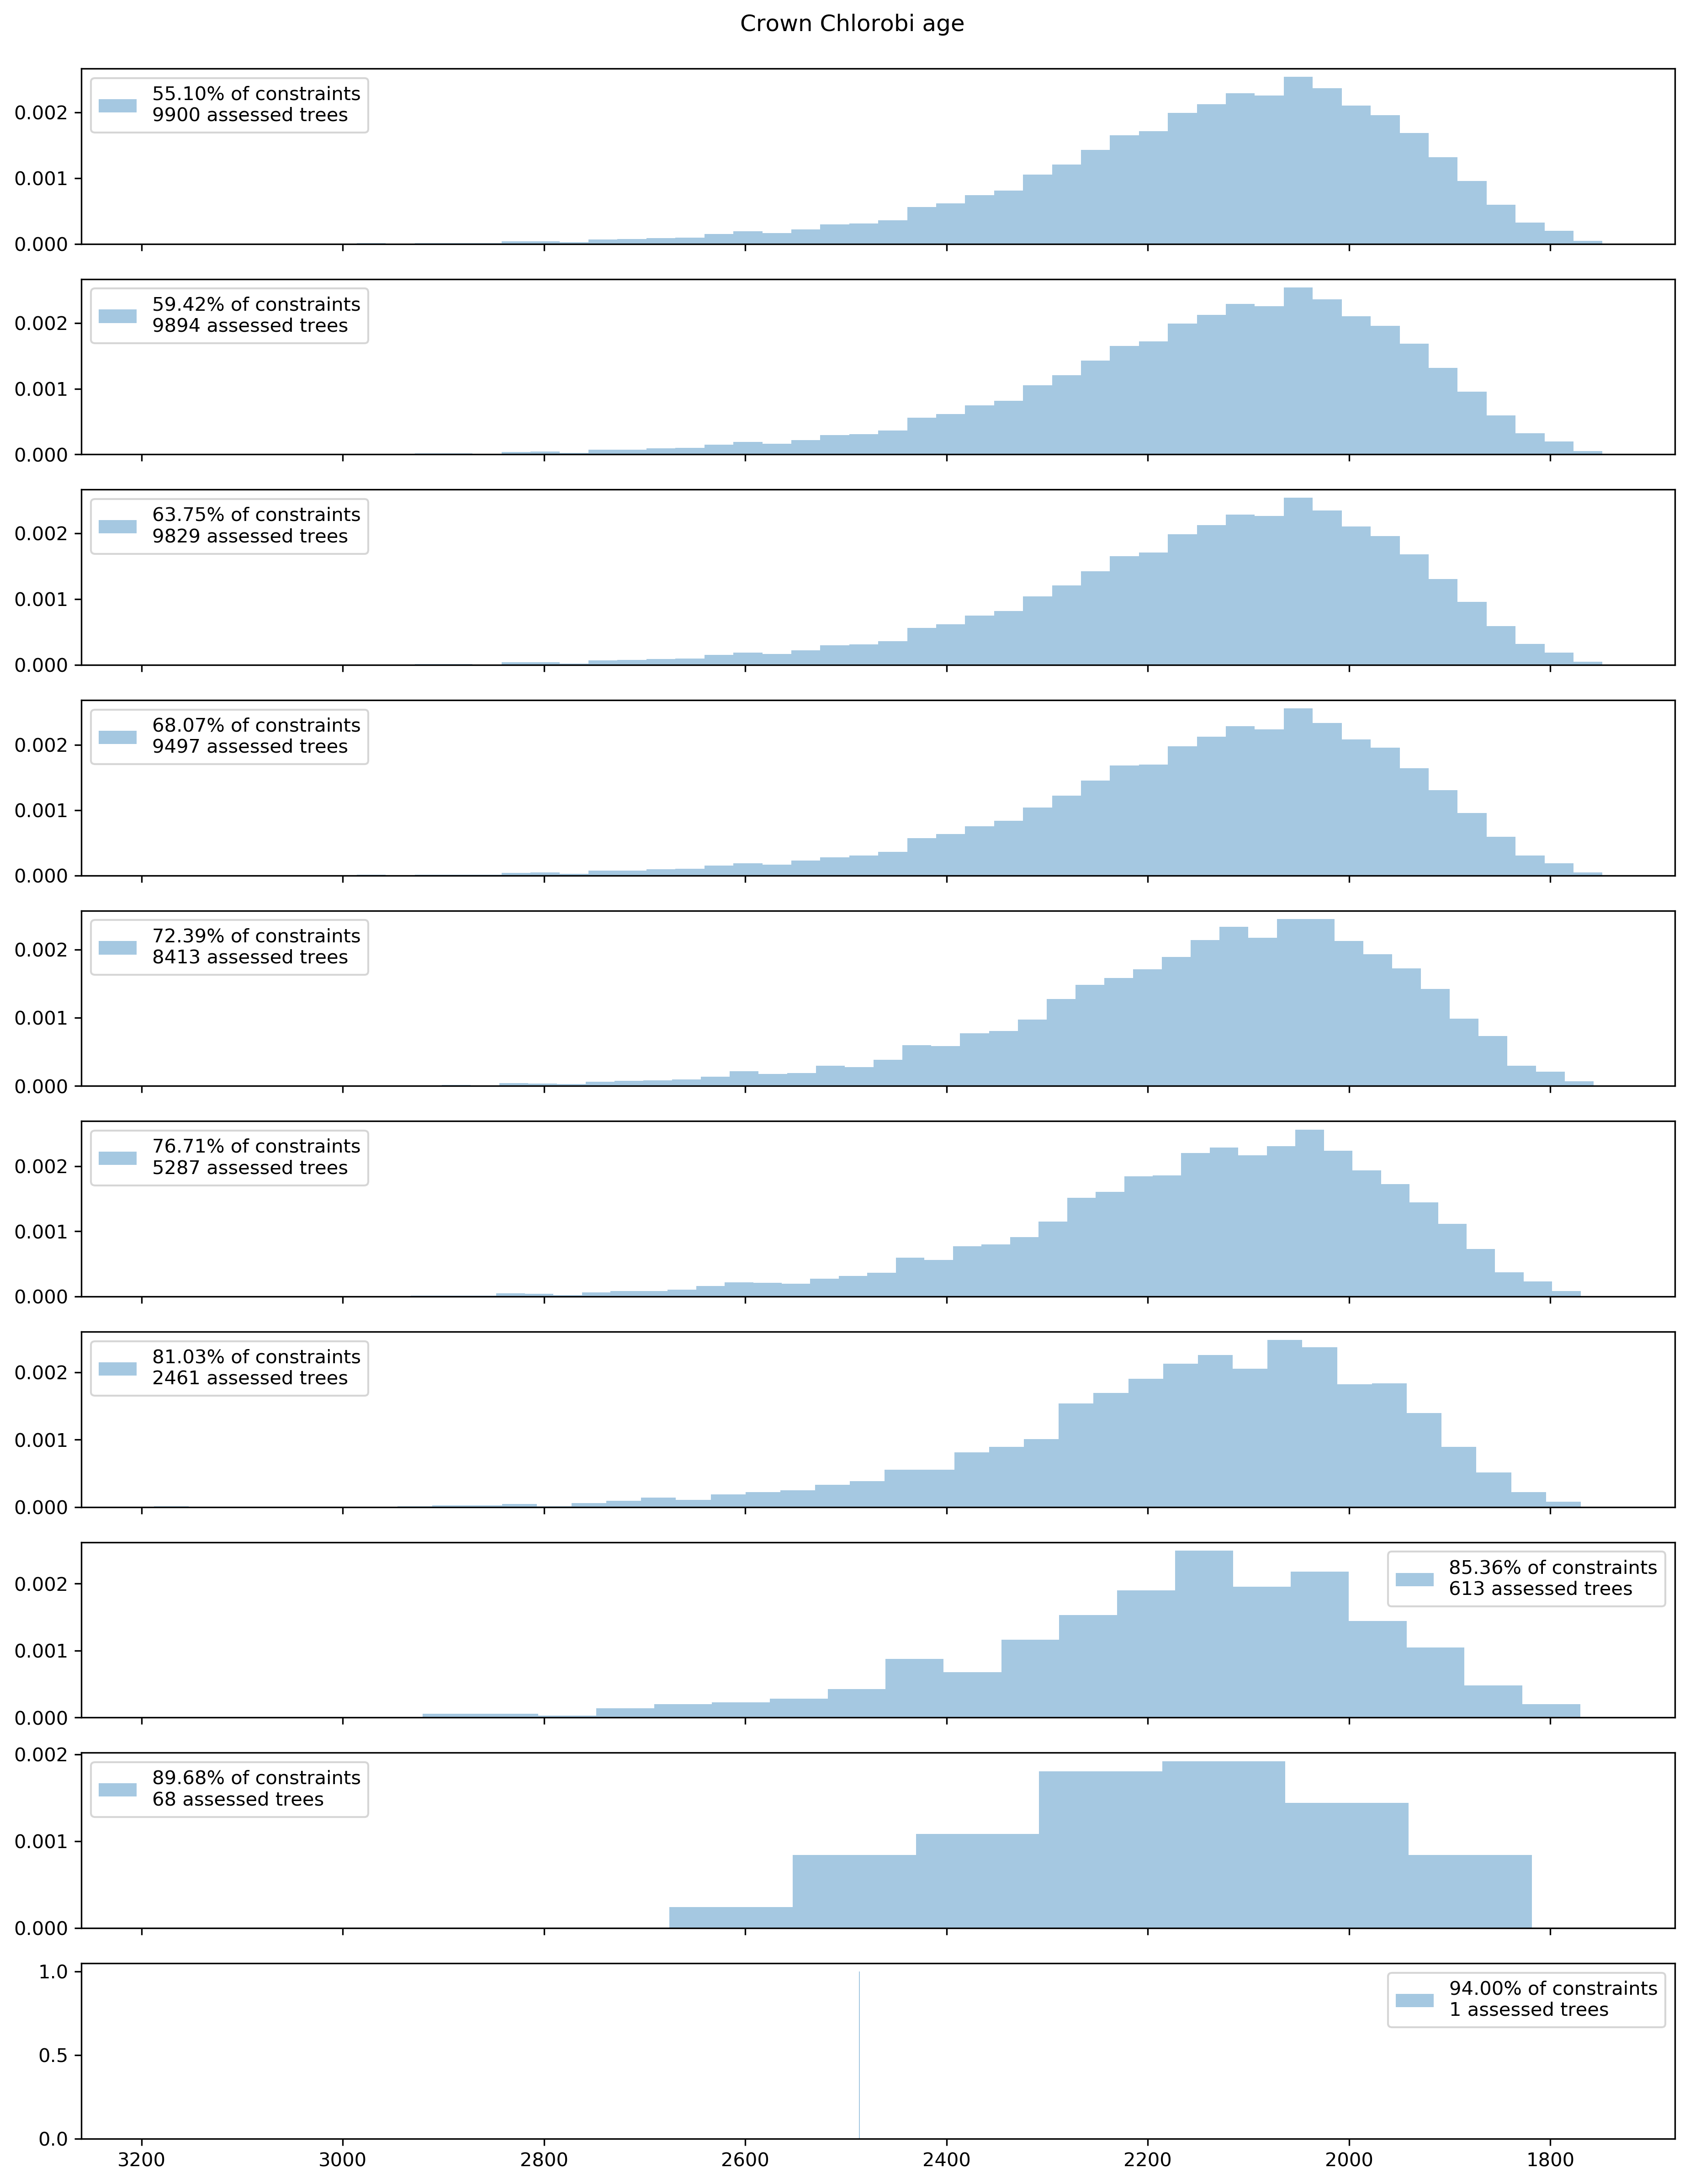

In [174]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n159']),
                        sharex=True)

fig.suptitle('Crown Chlorobi age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n159'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                ax=ax)
    ax.legend()
ax.invert_xaxis()

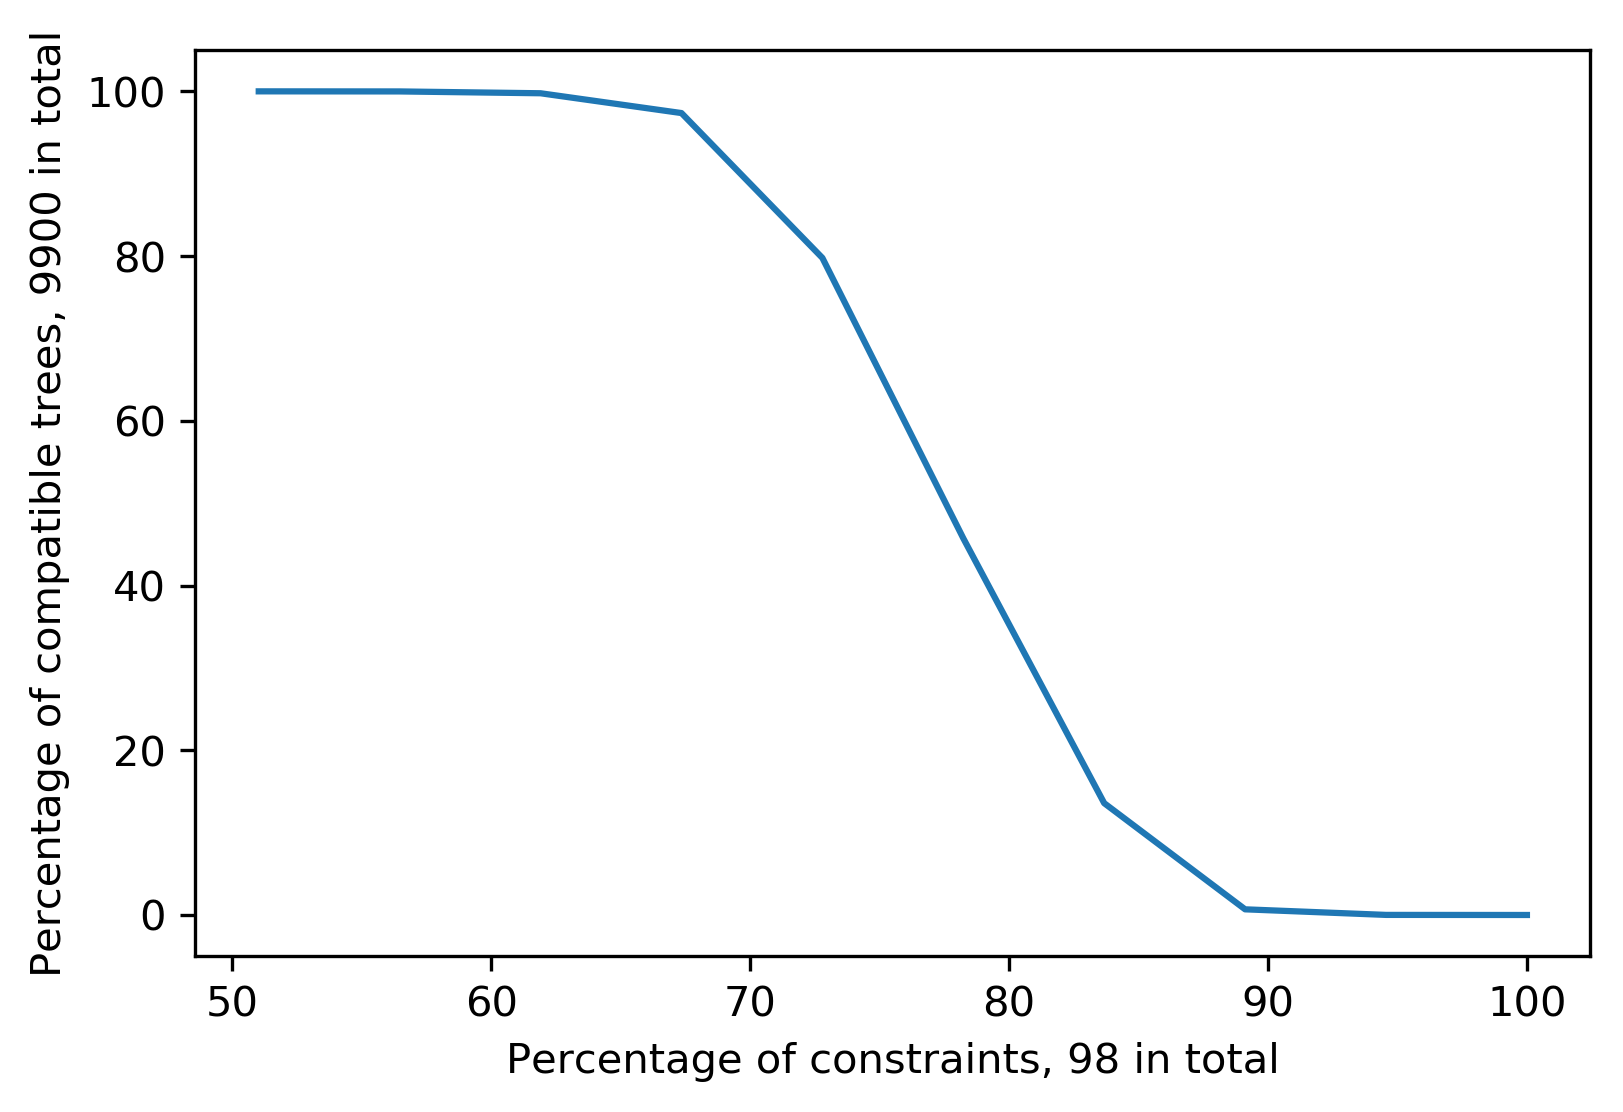

In [162]:
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Percentage of constraints, %i in total' % num_constraints)
ax.set_ylabel('Percentage of compatible trees, %i in total' % num_trees)
ax.plot((x/num_constraints)*100,
        y*100);

In [28]:
cluster0_coords = cluster_coords.loc[cluster0].copy()
cluster0_coords.sort_values(by='constraint_distance', ascending=False, inplace=True)

In [29]:
cluster0_coords.iloc[:5]

x         y cluster  cluster_size  compatibility_count  \
(n153, n43)  -0.074736 -0.266254       0           227                 9656   
(n114, n168) -0.083202 -0.267861       0           227                 9733   
(n137, n43)  -0.089754 -0.317725       0           227                 9261   
(n77, n168)  -0.069981 -0.292699       0           227                 9548   
(n144, n113) -0.083164 -0.277383       0           227                 9900   

              constraint_support  constraint_distance  
(n153, n43)                    1             2.421620  
(n114, n168)                   1             2.336984  
(n137, n43)                    3             2.321203  
(n77, n168)                    1             2.002586  
(n144, n113)                   1             1.997479

In [30]:
cluster0_coords.iloc[-5:]

x         y cluster  cluster_size  compatibility_count  \
(n96, n77)   -0.065871 -0.289165       0           227                 9560   
(n81, n71)   -0.026797 -0.252330       0           227                 8984   
(n70, n47)   -0.107211 -0.300421       0           227                 9365   
(n81, n75)   -0.074735 -0.252804       0           227                 9464   
(n165, n168) -0.095277 -0.163030       0           227                 8219   

              constraint_support  constraint_distance  
(n96, n77)                     1             0.124887  
(n81, n71)                     1             0.122510  
(n70, n47)                     1             0.115212  
(n81, n75)                     1             0.101823  
(n165, n168)                  20             0.096659

In [31]:
mt_black = set()
mt_green = set()
for line in open('maxtic.input_MT_output_partial_order').readlines():
    line = line.split()
    if line[-1] == 'black':
        mt_black.add((line[0], line[1]))
    else:
        mt_green.add((line[0], line[1]))
mt = mt_black.union(mt_green)

cluster0 = set(cluster_coords.query('cluster==0').index.tolist())
cluster1 = set(cluster_coords.query('cluster==1').index.tolist())

In [32]:
print('MaxTic VS this thing we are doing: %.4f' % 
      (len(mt.intersection(cluster0))/len(mt.union(cluster0)))
     )
print('MaxTic BLACK VS this thing we are doing: %.4f' % 
      (len(mt_black.intersection(cluster0))/len(mt_black.union(cluster0)))
     )
print('MaxTic GREEN VS this thing we are doing: %.4f' % 
      (len(mt_green.intersection(cluster0))/len(mt_green.union(cluster0)))
     )

MaxTic VS this thing we are doing: 0.4975
MaxTic BLACK VS this thing we are doing: 0.5655
MaxTic GREEN VS this thing we are doing: 0.0645
